In [1]:
# load required packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx
import networkx as nx
import pandas as pd
import re
import random
from ndex2.cx2 import CX2Network

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

#from gprofiler import GProfiler
#gp = GProfiler("MyToolName/0.1")

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

from datetime import datetime
import sys
%matplotlib inline
import networkx

In [2]:
# verify DDOT was installed
import ddot

from netcoloc import netprop_zscore, netprop, network_colocalization, validation


/tscc/nfs/home/hiyoothere/miniconda3/envs/r4/lib/python3.12/site-packages/netcoloc/validation.py:20: UserWarning: Import of ddot failed. NetColoc will not work properly: + cannot import name 'Ontology' from 'ddot' (/tscc/nfs/home/hiyoothere/miniconda3/envs/r4/lib/python3.12/site-packages/ddot/__init__.py)
  warnings.warn('Import of ddot failed. NetColoc will not work properly: + ' + str(ie))


## 2. Select two gene sets of interest. Load gene sets from text files into python.

In [3]:
d1_name='MM DNM gens'

In [4]:
#Get alias gene 
f_alias = open("/tscc/projects/ps-gleesonlab7/gleeson3/resources/HGNC/Gene_SYNONYM.txt", 'r')
dic_alias = {} #alias:general

for line in f_alias:
    if "Approved" not in line:
        s = line.strip().split("\t")
        #print (len(s))
        approved = s[0]
        if len(s) ==2:
            if ',' in s[1]:
                l_alias = s[1].split(',')
                for i in l_alias:
                    dic_alias[i.strip()] = approved
            else:
                dic_alias[s[1]] = approved
        elif len(s) == 3:
            if ',' in s[1]:
                l_alias = s[1].split(',')
                for i in l_alias:
                    
                    dic_alias[i.strip()] = approved
            else:
                dic_alias[s[1]] = approved
            if ',' in s[2]:
                l_previous = s[2].split(',')

                for i in l_previous:
                    dic_alias[i.strip()] = approved
            else:
                dic_alias[s[2]] = approved


In [5]:
# ------ customize this section based your input genesets -------

D1_df = pd.read_csv('/tscc/projects/ps-gleesonlab8/User/hiyoothere/NTD/5.Analysis/DNM/Burden/NTD_DamMC2_woINVALID.den_input',sep='\t')
D1_genes = D1_df['SYMBOL'].tolist()
#Remove duplicates
D1_genes = list(set(D1_genes))

        
print('Number of '+d1_name+' genes:',len(D1_genes))
print('First 5 genes:', D1_genes[0:5])

Number of MM DNM gens genes: 187
First 5 genes: ['GRIA3', 'SLC30A6', 'RXFP2', 'FAM83G', 'ZSWIM6']


# Output the overlap between the two gene sets
print('Number of '+d1_name+' and '+d2_name+' genes overlapping:', len(np.intersect1d(D1_genes,D2_genes)))

# Create a dictionary for each geneset
seed_dict = {d1_name:D1_genes,d2_name:D2_genes}

## 3. Select gene interaction network to use for the analysis.

In [6]:
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# remove self edges from network
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out the numbers of nodes and edges in the interatome for diagnostic purposes:
print('Number of nodes:', len(G_int.nodes))
print('\nNumber of edges:', len(G_int.edges))

Number of nodes: 18820

Number of edges: 2693109


In [7]:
int_nodes = list(G_int.nodes)

# Identify network colocalized gene network

## 4. Precalculate matrices needed for propagation. This step should take a few minutes (more for larger/denser networks)

In [8]:
# pre-calculate matrices used for network propagation. this step takes a few minutes, more for denser interactomes
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(G_int, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)




calculating w_prime

calculating w_double_prime


## 5. Subset seed genes to those found in the selected network.

In [9]:
for MM in D1_genes:
    if MM not in int_nodes:
        print (MM)

LAMA3
H3-4
SLCO1B3-SLCO1B7
MGA
MAP2
POP1


In [10]:
# subset seed genes to those found in interactome
print("Number of D1 genes:", len(D1_genes))


D1_new = []
for MM in D1_genes:
    if MM in int_nodes:
        D1_new.append(MM)
    if MM not in int_nodes:
        if MM in dic_alias:
            #print (MM, dic_alias[MM])
            D1_new.append(MM)
        else:
            print ("Not present", MM)
        
D1_genes = D1_new
print("Number of D1 genes in interactome:", len(D1_genes))

Number of D1 genes: 187
Not present H3-4
Not present SLCO1B3-SLCO1B7
Number of D1 genes in interactome: 185


##  6. Compute network proximity scores from seed gene set.


In [11]:
# D1 network propagation
print('\nCalculating D1 z-scores: ')
z_D1, Fnew_D1, Fnew_rand_D1 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    D1_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_D1 = pd.DataFrame({'z':z_D1})

z_D1.sort_values('z',ascending=False).head()


Calculating D1 z-scores: 


  0%|          | 0/1000 [00:00<?, ?it/s]

,z
CLTC,21.341222
HNRNPL,19.767824
VDAC2,19.187881
CNPY1,19.097940
FAM83G,17.947948


## 7. Build proximal subnetwork by taking z> thresh

In [12]:

# ----------- select thresholds for NetColoc -----------------
zthresh=3 # default = 3

# select the genes in the network intersection, make a subgraph

G_prox = nx.subgraph(G_int,z_D1[z_D1['z']>zthresh].index.tolist()) 
print("Nodes in proximal subgraph:", len(G_prox.nodes()))
print("Edges in proximal subgraph:", len(G_prox.edges()))




# compile dataframe of metadata for overlapping nodes
node_df = pd.DataFrame(index=list(G_prox.nodes))
node_df = node_df.assign(d1_seeds=0, d1_name=d1_name)
node_df.head()
node_df.loc[list(np.intersect1d(node_df['d1_seeds'].keys() ,D1_genes)), 'd1_seeds']=1
node_df['z_d1']=z_D1.loc[list(G_prox.nodes)]['z']
#node_df['z_d2']=z_D2.loc[list(G_overlap.nodes)]['z']
#node_df['z_both']=node_df['z_d1']*node_df['z_d2']
#node_df['sum_seeds']=node_df['d1_seeds']+node_df['d2_seeds']

node_df = node_df.sort_values('z_d1',ascending=False)
print (node_df.head(15))



Nodes in proximal subgraph: 439
Edges in proximal subgraph: 2447
          d1_seeds      d1_name       z_d1
CLTC             1  MM DNM gens  21.341222
HNRNPL           1  MM DNM gens  19.767824
VDAC2            1  MM DNM gens  19.187881
CNPY1            1  MM DNM gens  19.097940
FAM83G           1  MM DNM gens  17.947948
GTF3C3           1  MM DNM gens  17.852848
MFAP1            1  MM DNM gens  17.846594
DPYSL2           1  MM DNM gens  17.695655
LEMD3            1  MM DNM gens  16.780574
TOP2B            1  MM DNM gens  16.752226
C6orf132         1  MM DNM gens  16.370847
CRHR2            1  MM DNM gens  16.271097
SMURF2           1  MM DNM gens  16.069396
ATAD3B           1  MM DNM gens  15.869375
SPEN             1  MM DNM gens  15.622895


# ** Hypergeometric test

In [13]:
#1. Mouse gene and the DNM gene
MO_df = pd.read_csv('/tscc/projects/ps-gleesonlab8/User/hiyoothere/NTD/12.Network_propagation/MouseNTDgene/raw_221017.f.HumanConv.txt',sep='\t', encoding = "cp1252")
MO_genes = MO_df['gene'].tolist()
print('Number of Mouse NTD genes:',len(MO_genes))
print('First 5 genes:', MO_genes[0:5])

print('Number of DNM NTD genes:',len(D1_genes))
print('First 5 genes:', D1_genes[0:5], '\n\n')


overlap_DNM = np.intersect1d(D1_genes,MO_genes)
print('Number of overalps of DNM NTD genes and Mouse NTD genes:',len(overlap_DNM), '\n')
print('THOSE genes::', overlap_DNM)
cnt_overlap_DNM = len(overlap_DNM)
print ("\n\n\n")

#2. Mouse gene and propagated genes

Prop_genes = node_df['d1_seeds'].keys()
print('Number of Prop_genes:',len(Prop_genes))
print('First 5 genes:', Prop_genes[0:5])



overlap_prop = np.intersect1d(MO_genes,Prop_genes)
print('Number of overalps of Prop genes genes and Mouse NTD genes:',len(overlap_prop), '\n')
print('THOSE genes::', overlap_prop)
cnt_overlap_prop = len(overlap_prop)
print ("\n\n\n")




Number of Mouse NTD genes: 374
First 5 genes: ['EFNA5', 'EPHA7', 'FREM1', 'FREM2', 'GJA1']
Number of DNM NTD genes: 185
First 5 genes: ['GRIA3', 'SLC30A6', 'RXFP2', 'FAM83G', 'ZSWIM6'] 


Number of overalps of DNM NTD genes and Mouse NTD genes: 11 

THOSE genes:: ['CELSR1' 'EP300' 'FREM1' 'GRHL2' 'GRHL3' 'MIB2' 'PAX3' 'SCRIB' 'SMURF2'
 'TBXT' 'TIAM1']




Number of Prop_genes: 439
First 5 genes: Index(['CLTC', 'HNRNPL', 'VDAC2', 'CNPY1', 'FAM83G'], dtype='object')
Number of overalps of Prop genes genes and Mouse NTD genes: 17 

THOSE genes:: ['BMP7' 'CELSR1' 'DYNC2H1' 'EP300' 'FREM1' 'FREM2' 'GRHL2' 'GRHL3' 'MIB2'
 'PAX3' 'SCRIB' 'SLC25A19' 'SMURF2' 'SS18' 'TBXT' 'TIAM1' 'TULP3']






In [14]:
from scipy.stats import hypergeom
import matplotlib.pyplot as plt

In [15]:
[M, n, N] = [18820, len(MO_genes), len(G_prox.nodes())]
#https://www.science.org/doi/10.1126/science.abj6987
#M = KNOWN NTD GENE ( MOUSE GENE)
#N = CNT_PROP_GENE
rv = hypergeom(M, n, N)
#rv = hypergeom(20, 7, 12)
x = np.arange(0, n+1)
pmf = rv.pmf(x)
pmf

array([1.34076912e-004, 1.22243180e-003, 5.54482682e-003, 1.66831247e-002,
       3.74576026e-002, 6.69420512e-002, 9.91922661e-002, 1.25344513e-001,
       1.37889401e-001, 1.34149284e-001, 1.16860355e-001, 9.20717947e-002,
       6.61553653e-002, 4.36519228e-002, 2.66080628e-002, 1.50594962e-002,
       7.94920474e-003, 3.92868290e-003, 1.82423114e-003, 7.98286880e-004,
       3.30128623e-004, 1.29340228e-004, 4.81160856e-005, 1.70312077e-005,
       5.74665119e-006, 1.85159957e-006, 5.70599659e-007, 1.68424387e-007,
       4.76823320e-008, 1.29639451e-008, 3.38886739e-009, 8.52680339e-010,
       2.06717905e-010, 4.83334880e-011, 1.09091026e-011, 2.37886745e-012,
       5.01579822e-013, 1.02335723e-013, 2.02182114e-014, 3.87062255e-015,
       7.18489806e-016, 1.29397842e-016, 2.26230890e-017, 3.84180072e-018,
       6.34021624e-019, 1.01736611e-019, 1.58804269e-020, 2.41244417e-021,
       3.56822606e-022, 5.14078087e-023, 7.21707897e-024, 9.87679965e-025,
       1.31811545e-025, 1

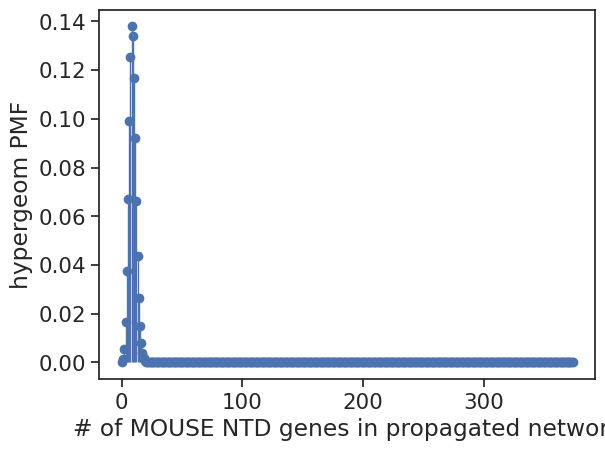

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, pmf, 'bo')
ax.vlines(x, 0, pmf, lw=1)
ax.set_xlabel('# of MOUSE NTD genes in propagated network')
ax.set_ylabel('hypergeom PMF')
plt.show()

In [17]:
prb = hypergeom.cdf(len(overlap_prop), M, n, N) 
prb
(1-prb)/2

0.0015777682995173348

In [23]:
G_prox_cx = ndex2.create_nice_cx_from_networkx(G_prox)
network_uuid_hier = G_prox_cx.upload_to('ndexbio.org', 'jiny', 'xhflxhfl12')

Generating CX


In [68]:
uuid = G_prox_cx.upload_to(server='public.ndexbio.org',
                  username='hijiny01@gmail.com',
                  password='xhflxhfl12')

G_prox_cx = ndex2.create_nice_cx_from_networkx(G_prox)

Generating CX


HTTPError: 401 Client Error: 401 for url: http://public.ndexbio.org/v2/network

In [50]:
import networkx as nx
type(G_prox_cx)
__all__ = ["cytoscape_data", "cytoscape_graph"]
networkx.cytoscape_graph(G_prox_cx, name='MM.cyjs', ident='id')

AttributeError: 'NiceCXNetwork' object has no attribute 'get'

In [43]:
#G_prox_cx.upload_to('ndexbio.org', 'hijiny01@gmail.com', 'xhflxhfl12')

#Upload to NDEx. Enter your ndex username and password. 
# If you are new to ndex, make a new account on the website (ndexbio.org)
G_prox_cx.set_name(d1_name+'_systems_map') 
SERVER = input('NDEx server : http://public.ndexbio.org/')
USERNAME = input('NDEx user name: hijiny01@gmail.com')
PASSWORD = getpass.getpass('NDEx password: xhflxhfl12')
network_uuid_hier = G_prox_cx.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server : http://public.ndexbio.org/ 
NDEx user name: hijiny01@gmail.com 
NDEx password: xhflxhfl12 ········


InvalidURL: Invalid URL 'http:///rest/admin/status': No host supplied

### you used N as the total number of genes (~19,000), M as the number of known NTD genes, and s (sample size) as the number of genes from network propagation and the k (number of success in the sample) as the number of genes overlapping with the NTD genes in the network propagation result. Did I understand the method clearly?

In [76]:
node_df["gene"] =node_df.index
print (node_df)
print (node_df["gene"])

         d1_seeds      d1_name       z_d1     gene
CLTC            1  MM DNM gens  21.341222     CLTC
HNRNPL          1  MM DNM gens  19.767824   HNRNPL
VDAC2           1  MM DNM gens  19.187881    VDAC2
CNPY1           1  MM DNM gens  19.097940    CNPY1
FAM83G          1  MM DNM gens  17.947948   FAM83G
...           ...          ...        ...      ...
TTN             0  MM DNM gens   3.014179      TTN
MRPL9           0  MM DNM gens   3.010165    MRPL9
SLC4A10         0  MM DNM gens   3.007231  SLC4A10
WIPF3           0  MM DNM gens   3.006245    WIPF3
TMIGD1          0  MM DNM gens   3.005495   TMIGD1

[439 rows x 4 columns]
CLTC          CLTC
HNRNPL      HNRNPL
VDAC2        VDAC2
CNPY1        CNPY1
FAM83G      FAM83G
            ...   
TTN            TTN
MRPL9        MRPL9
SLC4A10    SLC4A10
WIPF3        WIPF3
TMIGD1      TMIGD1
Name: gene, Length: 439, dtype: object


In [77]:
#print (node_df.head(15))
for col in node_df.columns:
    print(col)
#node_df.rename(columns = {"Gene", "seed", "geneSet", "z_d1", "Mouse_NTDgene"})
print (overlap_prop)
print (node_df["gene"])
node_df["Mouse_Gene"] = np.where(node_df["gene"].isin(overlap_prop), "MouseNTD", "0")
print (node_df)
node_df.to_csv("/projects/ps-gleesonlab8/User/hiyoothere/NTD/5.Analysis/Network/output/NTD_DamMC2_coloc.txt", sep = '\t')



d1_seeds
d1_name
z_d1
gene
['BMP7' 'CELSR1' 'DYNC2H1' 'EP300' 'FREM1' 'FREM2' 'GRHL2' 'GRHL3' 'MIB2'
 'PAX3' 'SCRIB' 'SLC25A19' 'SMURF2' 'SS18' 'TBXT' 'TIAM1' 'TULP3']
CLTC          CLTC
HNRNPL      HNRNPL
VDAC2        VDAC2
CNPY1        CNPY1
FAM83G      FAM83G
            ...   
TTN            TTN
MRPL9        MRPL9
SLC4A10    SLC4A10
WIPF3        WIPF3
TMIGD1      TMIGD1
Name: gene, Length: 439, dtype: object
         d1_seeds      d1_name       z_d1     gene Mouse_Gene
CLTC            1  MM DNM gens  21.341222     CLTC          0
HNRNPL          1  MM DNM gens  19.767824   HNRNPL          0
VDAC2           1  MM DNM gens  19.187881    VDAC2          0
CNPY1           1  MM DNM gens  19.097940    CNPY1          0
FAM83G          1  MM DNM gens  17.947948   FAM83G          0
...           ...          ...        ...      ...        ...
TTN             0  MM DNM gens   3.014179      TTN          0
MRPL9           0  MM DNM gens   3.010165    MRPL9          0
SLC4A10         0  MM DNM 

SyntaxError: invalid syntax (1744613418.py, line 5)

# Compute systems map from proximal subgraph

## 9. Convert network colocalization subnetwork to form used in community detection module

In [22]:
# compile dataframe of metadata for overlapping nodes
node_df = pd.DataFrame(index=list(G_prox.nodes))
node_df = node_df.assign(d1_seeds=0, d1_name=d1_name,)
node_df.loc[list(np.intersect1d(D1_genes,node_df.index.tolist())), 'd1_seeds']=1
node_df['z_d1']=z_D1.loc[list(G_prox.nodes)]['z']
node_df['sum_seeds']=node_df['d1_seeds']

node_df = node_df.sort_values('z_d1',ascending=False)
node_df.head(15)

,d1_seeds,d1_name,z_d1,sum_seeds
CLTC,1,MM DNM gens,21.341222,1
HNRNPL,1,MM DNM gens,19.767824,1
VDAC2,1,MM DNM gens,19.187881,1
CNPY1,1,MM DNM gens,19.097940,1
FAM83G,1,MM DNM gens,17.947948,1
GTF3C3,1,MM DNM gens,17.852848,1
MFAP1,1,MM DNM gens,17.846594,1
DPYSL2,1,MM DNM gens,17.695655,1
LEMD3,1,MM DNM gens,16.780574,1
TOP2B,1,MM DNM gens,16.752226,1


## 10. Run community detection on NetColoc subnetwork (recommend HiDef).

In [20]:
G_prox_cx = ndex2.create_nice_cx_from_networkx(G_prox)


In [80]:
print("Nodes in overlap subgraph:", len(G_prox.nodes()))
print("Edges in overlap subgraph:", len(G_prox.edges()))
# Create cx format of overlap subgraph
G_prox_cx = ndex2.create_nice_cx_from_networkx(G_prox)
G_prox_cx.set_name(d1_name+'_NetColoc_subgraph') 
for node_id, node in G_prox_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_prox_cx.set_node_attribute(node_id, row, value, type=data_type)

cd = cdapsutil.CommunityDetection()

# Run HiDeF on CDAPS REST service
G_hier = cd.run_community_detection(G_prox_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'20'})

Nodes in overlap subgraph: 439
Edges in overlap subgraph: 2447


In [81]:
# Print information about hierarchy
print('Hierarchy name: ' + str(G_hier.get_name()))
print('# nodes: ' + str(len(G_hier.get_nodes())))
print('# edges: ' + str(len(G_hier.get_edges())))

Hierarchy name: hidefv1.1beta_(none)_MM DNM gens_NetColoc_subgraph
# nodes: 117
# edges: 131


## 11. Convert the NetColoc hierarchy to networkx format, and write out features of the hierarchy to a pandas dataframe, for easier access in Python.

In [82]:
G_hier = G_hier.to_networkx(mode='default')
G_hier

nodes = G_hier.nodes()

# print the number of nodes and edges in the hierarchy for diagnostic purposes
print('Number of nodes:', len(G_hier.nodes()))

print('\nNumber of edges:', len(G_hier.edges()))

Number of nodes: 117

Number of edges: 131


In [83]:
# add node attributes to dataframe for easier access
hier_df = pd.DataFrame.from_dict(dict(G_hier.nodes(data=True)), orient='index')
hier_df['system_ID']=hier_df.index.tolist()
# some columns are not the right type
hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
hier_df.head()





,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID
0,TMEM143 USP17L1 PLCL2 BORCS6 ZNF791 CTAG1B FNI...,434,False,8.762,,,0,0.0,0.0,120,C439,C439,0
1,ZNF180 NUFIP1 ZNF181 MFAP1 UBIAD1,5,False,2.322,,,0,0.0,0.0,5,C516,C516,1
2,SQOR CXXC5 EHD4 SMAD3 STYXL1,5,False,2.322,,,0,0.0,0.0,5,C517,C517,2
3,FNIP2 MED13L METRNL ZSWIM6,4,False,2.0,,,0,0.0,0.0,43,C518,C518,3
4,VWA8 MMUT PCK2 MCM9,4,False,2.0,,,0,0.0,0.0,27,C524,C524,4


## 12. Remove systems with no seed genes (OPTIONAL)

In [84]:
hier_df.index=hier_df['name']
hier_df.head()

num_d1_seeds = []
frac_d1_seeds=[]

systems_keep = []
for c in hier_df.index.tolist():
    system_genes = hier_df['CD_MemberList'].loc[c].split(' ')
    d1_temp = list(np.intersect1d(system_genes,D1_genes))

    num_d1_temp = len(d1_temp)
    if (num_d1_temp)>0: # keep the system if it has at least 1 seed gene
        systems_keep.append(c)
        num_d1_seeds.append(num_d1_temp)
        
        frac_d1_seeds.append((num_d1_temp)/float(len(system_genes)))

        
frac_no_seeds = np.subtract(1.0,np.array([frac_d1_seeds]).sum(axis=0))

hier_df = hier_df.loc[systems_keep]
hier_df['num_d1_seeds']=num_d1_seeds
hier_df['frac_d1_seeds']=frac_d1_seeds
hier_df['frac_no_seeds']=frac_no_seeds
print("Number of nodes with seed genes:", len(hier_df))

hier_df.head(30)

Number of nodes with seed genes: 117


,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID,num_d1_seeds,frac_d1_seeds,frac_no_seeds
name,,,,,,,,,,,,,,,,
C439,TMEM143 USP17L1 PLCL2 BORCS6 ZNF791 CTAG1B FNI...,434,False,8.762,,,0,0.0,0.0,120,C439,C439,0,178,0.410138,0.589862
C516,ZNF180 NUFIP1 ZNF181 MFAP1 UBIAD1,5,False,2.322,,,0,0.0,0.0,5,C516,C516,1,3,0.600000,0.400000
C517,SQOR CXXC5 EHD4 SMAD3 STYXL1,5,False,2.322,,,0,0.0,0.0,5,C517,C517,2,2,0.400000,0.600000
C518,FNIP2 MED13L METRNL ZSWIM6,4,False,2.0,,,0,0.0,0.0,43,C518,C518,3,2,0.500000,0.500000
C524,VWA8 MMUT PCK2 MCM9,4,False,2.0,,,0,0.0,0.0,27,C524,C524,4,3,0.750000,0.250000
C529,TBCB SCAP LIN37 MAP4,4,False,2.0,,,0,0.0,0.0,15,C529,C529,5,1,0.250000,0.750000
C533,DCP1A NSMAF NBEAL1 WDFY4,4,False,2.0,,,0,0.0,0.0,12,C533,C533,6,2,0.500000,0.500000
C535,P2RX5 C7orf26 PPP4R1 BRAT1,4,False,2.0,,,0,0.0,0.0,11,C535,C535,7,2,0.500000,0.500000
C539,PPP1R2 CLIP1 CLASP2 DCTN6,4,False,2.0,,,0,0.0,0.0,9,C539,C539,8,1,0.250000,0.750000


In [85]:
print (hier_df["CD_MemberList_LogSize"].sort_values())

name
C541      2.0
C522      2.0
C531      2.0
C532      2.0
C540      2.0
        ...  
C443      5.7
C442    5.858
C441     6.57
C440    7.219
C439    8.762
Name: CD_MemberList_LogSize, Length: 117, dtype: object


In [86]:
# prune G_hier--> only keep systems with at least one seed gene

nkeep=[]
for n in list(G_hier.nodes()):
    if G_hier.nodes(data=True)[n]['name'] in systems_keep:
        nkeep.append(n)
        

G_hier = nx.subgraph(G_hier, nkeep)
print("Number of nodes with seed genes:", len(G_hier.nodes()))
print("Number of edges remaining:", len(G_hier.edges()))

Number of nodes with seed genes: 117
Number of edges remaining: 131


## 13. Sneak peek of hierarchy visualization (OPTIONAL)

In [87]:
network_colocalization.view_G_hier(G_hier)

CytoscapeWidget(cytoscape_layout={'name': 'cose'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

## 14. Annotate systems with gprofiler.

In [88]:
# gprofiler annotation of clusters

system_name_list = []
for p in hier_df.index.tolist():
    focal_genes=hier_df['CD_MemberList'].loc[p].split(' ')
    print(p)
    print(len(focal_genes))
    if len(focal_genes)>2:
        gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['REAC']))
        if len(gp_temp)>0: # make sure data is not empty
            
            # make sure terms are specific, and overlap with at least 3 genes
            gp_temp = gp_temp[(gp_temp['term_size']<1000)&(gp_temp['term_size']>50)]
            gp_temp = gp_temp[gp_temp['intersection_size']>=3]
            
            gp_temp = gp_temp[gp_temp['p_value']<1E-5] # set a stringent pvalue threshold
            
            gp_temp = gp_temp.sort_values('recall',ascending=False)
            
            if len(gp_temp)>1:
                system_name_list.append(gp_temp.head(1)['name'].tolist()[0])
            else:
                system_name_list.append(p)
        else:
            system_name_list.append(p)
            

        display(gp_temp.head())
        
    else:
        system_name_list.append(p)

C439
434


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,RHO GTPase cycle,10835,30,RHO GTPase cycle,REAC:R-HSA-9012999,0.000008,[REAC:R-HSA-194315],0.129310,query_1,232,0.066815,True,REAC,449
0,Signaling by Rho GTPases,10835,40,Signaling by Rho GTPases,REAC:R-HSA-194315,0.000008,[REAC:R-HSA-9716542],0.172414,query_1,232,0.056980,True,REAC,702
1,"Signaling by Rho GTPases, Miro GTPases and RHO...",10835,40,"Signaling by Rho GTPases, Miro GTPases and RHO...",REAC:R-HSA-9716542,0.000008,[REAC:R-HSA-162582],0.172414,query_1,232,0.055788,True,REAC,717


C516
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C517
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C518
4


""


C524
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C529
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C533
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C535
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C539
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C542
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C547
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C440
149


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Nervous system development,10835,22,Nervous system development,REAC:R-HSA-9675108,2.541969e-07,[REAC:R-HSA-1266738],0.250000,query_1,88,0.038328,True,REAC,574
1,Axon guidance,10835,21,Axon guidance,REAC:R-HSA-422475,3.504396e-07,[REAC:R-HSA-9675108],0.238636,query_1,88,0.038251,True,REAC,549


C441
95


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C442
58


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Chromatin modifying enzymes,10835,11,Chromatin modifying enzymes,REAC:R-HSA-3247509,3.294937e-09,[REAC:R-HSA-4839726],0.392857,query_1,28,0.040293,True,REAC,273
1,Chromatin organization,10835,11,Chromatin organization,REAC:R-HSA-4839726,3.294937e-09,[REAC:0000000],0.392857,query_1,28,0.040293,True,REAC,273


C445
33


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C446
31


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C447
29


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C448
28


""


C453
19


""


C457
12


""


C464
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C468
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C471
8


""


C473
8


""


C480
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C481
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C484
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C488
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C489
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C490
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C491
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C495
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C496
5


""


C501
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C511
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C512
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C449
27


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Clathrin-mediated endocytosis,10835,10,Clathrin-mediated endocytosis,REAC:R-HSA-8856828,1.349967e-11,[REAC:R-HSA-199991],0.434783,query_1,23,0.069444,True,REAC,144
12,Parasite infection,10835,6,Parasite infection,REAC:R-HSA-9664407,7.158181e-07,[REAC:R-HSA-9658195],0.260870,query_1,23,0.053097,True,REAC,113
13,Leishmania phagocytosis,10835,6,Leishmania phagocytosis,REAC:R-HSA-9664417,7.158181e-07,[REAC:R-HSA-9664407],0.260870,query_1,23,0.053097,True,REAC,113
14,FCGR3A-mediated phagocytosis,10835,6,FCGR3A-mediated phagocytosis,REAC:R-HSA-9664422,7.158181e-07,[REAC:R-HSA-9664417],0.260870,query_1,23,0.053097,True,REAC,113
15,Regulation of actin dynamics for phagocytic cu...,10835,6,Regulation of actin dynamics for phagocytic cu...,REAC:R-HSA-2029482,7.837873e-07,[REAC:R-HSA-2029480],0.260870,query_1,23,0.051724,True,REAC,116


C544
4


""


C451
21


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C549
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C487
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C522
4


""


C459
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C460
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C492
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C462
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C466
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C531
4


""


C532
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C472
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Ion homeostasis,10835,4,Ion homeostasis,REAC:R-HSA-5578775,0.000002,[REAC:R-HSA-5576891],0.5,query_1,8,0.074074,True,REAC,54


C540
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C478
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C546
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C458
12


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C527
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C500
5


""


C469
8


""


C538
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C443
52


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C477
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C479
7


""


C523
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C552
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C452
19


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Chromatin modifying enzymes,10835,5,Chromatin modifying enzymes,REAC:R-HSA-3247509,0.000001,[REAC:R-HSA-4839726],0.833333,query_1,6,0.018315,True,REAC,273
1,Chromatin organization,10835,5,Chromatin organization,REAC:R-HSA-4839726,0.000001,[REAC:0000000],0.833333,query_1,6,0.018315,True,REAC,273


C444
34


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C519
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C493
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C497
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Antigen processing: Ubiquitination & Proteasom...,10835,5,Antigen processing: Ubiquitination & Proteasom...,REAC:R-HSA-983168,9.170868e-07,[REAC:R-HSA-983169],1.0,query_1,5,0.016234,True,REAC,308
1,Class I MHC mediated antigen processing & pres...,10835,5,Class I MHC mediated antigen processing & pres...,REAC:R-HSA-983169,1.318986e-06,[REAC:R-HSA-1280218],1.0,query_1,5,0.013158,True,REAC,380


C498
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Macroautophagy,10835,4,Macroautophagy,REAC:R-HSA-1632852,1.889756e-07,[REAC:R-HSA-9612973],1.0,query_1,4,0.029851,True,REAC,134
0,Autophagy,10835,4,Autophagy,REAC:R-HSA-9612973,1.889756e-07,[REAC:0000000],1.0,query_1,4,0.026846,True,REAC,149


C502
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C536
4


""


C537
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C514
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C467
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C454
17


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C545
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C450
22


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C482
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C455
15


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C476
7


""


C456
15


""


C461
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Clathrin-mediated endocytosis,10835,7,Clathrin-mediated endocytosis,REAC:R-HSA-8856828,1.178411e-09,[REAC:R-HSA-199991],0.636364,query_1,11,0.048611,True,REAC,144


C463
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
3,FCGR3A-mediated phagocytosis,10835,4,FCGR3A-mediated phagocytosis,REAC:R-HSA-9664422,0.000003,[REAC:R-HSA-9664417],0.571429,query_1,7,0.035398,True,REAC,113
5,Parasite infection,10835,4,Parasite infection,REAC:R-HSA-9664407,0.000003,[REAC:R-HSA-9658195],0.571429,query_1,7,0.035398,True,REAC,113
7,Leishmania phagocytosis,10835,4,Leishmania phagocytosis,REAC:R-HSA-9664417,0.000003,[REAC:R-HSA-9664407],0.571429,query_1,7,0.035398,True,REAC,113
2,Regulation of actin dynamics for phagocytic cu...,10835,4,Regulation of actin dynamics for phagocytic cu...,REAC:R-HSA-2029482,0.000003,[REAC:R-HSA-2029480],0.571429,query_1,7,0.034483,True,REAC,116
9,Fcgamma receptor (FCGR) dependent phagocytosis,10835,4,Fcgamma receptor (FCGR) dependent phagocytosis,REAC:R-HSA-2029480,0.000005,[REAC:R-HSA-168249],0.571429,query_1,7,0.028571,True,REAC,140


C483
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C553
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C474
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C465
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C515
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C485
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C555
4


""


C507
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C534
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C470
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C494
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C508
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C499
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C509
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C504
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C520
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Clathrin-mediated endocytosis,10835,4,Clathrin-mediated endocytosis,REAC:R-HSA-8856828,0.000001,[REAC:R-HSA-199991],1.0,query_1,4,0.027778,True,REAC,144


C475
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C530
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C486
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C505
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C513
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Ion homeostasis,10835,3,Ion homeostasis,REAC:R-HSA-5578775,0.000009,[REAC:R-HSA-5576891],0.6,query_1,5,0.055556,True,REAC,54
1,Transport of small molecules,10835,5,Transport of small molecules,REAC:R-HSA-382551,0.000009,[REAC:0000000],1.0,query_1,5,0.006964,True,REAC,718


C526
4


""


C506
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C543
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C525
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C503
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C554
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C551
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C548
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C510
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C521
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C528
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C550
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C541
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


In [90]:
hier_df.to_csv("/projects/ps-gleesonlab8/User/hiyoothere/NTD/5.Analysis/Network/output/9.subnet_coloc_heir.txt", sep = '\t')

In [88]:
head(hier_df)

NameError: name 'head' is not defined

## Compute network colocalized systems map

## 9. Convert network colocalization subnetwork to form used in community detection module

In [91]:
# compile dataframe of metadata for overlapping nodes
node_df = pd.DataFrame(index=list(G_overlap.nodes))
node_df = node_df.assign(d1_seeds=0, d2_seeds=0, d1_name=d1_name, d2_name=d2_name)
node_df.loc[list(np.intersect1d(seed_dict[d1_name],node_df.index.tolist())), 'd1_seeds']=1
node_df.loc[list(np.intersect1d(seed_dict[d2_name],node_df.index.tolist())), 'd2_seeds']=1
node_df['z_d1']=z_D1.loc[list(G_overlap.nodes)]['z']
#node_df['z_d2']=z_D2.loc[list(G_overlap.nodes)]['z']
#node_df['z_both']=node_df['z_d1']*node_df['z_d2']
#node_df['sum_seeds']=node_df['d1_seeds']+node_df['d2_seeds']

node_df = node_df.sort_values('z_d1',ascending=False)
print (node_df.head(15))
node_df.to_csv("/projects/ps-gleesonlab8/User/hiyoothere/NTD/5.Analysis/Network/output/output/9.subnet_coloc.txt", sep = '\t')


NameError: name 'G_overlap' is not defined

## 10. Run community detection on NetColoc subnetwork (recommend HiDef).

In [92]:
print("Nodes in overlap subgraph:", len(G_overlap.nodes()))
print("Edges in overlap subgraph:", len(G_overlap.edges()))
# Create cx format of overlap subgraph
G_overlap_cx = ndex2.create_nice_cx_from_networkx(G_overlap)
G_overlap_cx.set_name(d1_name+'_'+d2_name+'_NetColoc_subgraph') 
for node_id, node in G_overlap_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_overlap_cx.set_node_attribute(node_id, row, value, type=data_type)

cd = cdapsutil.CommunityDetection()
print (G_overlap_cx)
# Run HiDeF on CDAPS REST service
G_hier = cd.run_community_detection(G_overlap_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'20'})
print (G_hier)

NameError: name 'G_overlap' is not defined

In [93]:
# Print information about hierarchy
print('Hierarchy name: ' + str(G_hier.get_name()))
print('# nodes: ' + str(len(G_hier.get_nodes())))
print('# edges: ' + str(len(G_hier.get_edges())))

AttributeError: 'MultiDiGraph' object has no attribute 'get_name'

In [94]:
sr = cdapsutil.ServiceRunner()
sr.get_algorithms() # this will print out available options for each algorithm

DISCLAIMIER: cdapsutil is experimental and may contain errors and interfaces may change


{'algorithms': {'hidef': {'name': 'hidef',
   'displayName': 'HiDeF',
   'description': "Runs <a href='https://github.com/fanzheng10/HiDeF'>HiDeF</a> community detection algorithm.<br/><br/>Paper:<br/>Zheng, F., Zhang, S., Churas, C., Pratt, D., Bahar, I., Ideker, T. HiDeF: identifying persistent structures in<br/>multiscale ‘omics data. Genome Biol 22, 21 (2021).<br/><a href='https://doi.org/10.1186/s13059-020-02228-4'>10.1186/s13059-020-02228-4</a><br/><br/><b>NOTE:</b> For reasonable runtime, the maximum size of input network should not exceed 20k nodes and 400k edges.<br/><br/><a href='https://github.com/idekerlab/cdhidef'>Click here for more information</a>",
   'version': '0.2.2',
   'dockerImage': 'coleslawndex/cdhidef:0.2.2',
   'inputDataFormat': 'EDGELISTV2',
   'outputDataFormat': 'COMMUNITYDETECTRESULTV2',
   'customParameters': [{'name': '--maxres',
     'displayName': 'Maximum resolution parameter',
     'description': 'Maximum resolution parameter. Increase to get more s

## 11. Convert the NetColoc hierarchy to networkx format, and write out features of the hierarchy to a pandas dataframe, for easier access in Python.

In [95]:
G_hier = G_hier.to_networkx(mode='default')
#G_hier.to_csv("output/G_hier.txt", sep = '\t')
print (G_hier)
nodes = G_hier.nodes()

# print the number of nodes and edges in the hierarchy for diagnostic purposes
print('Number of nodes:', len(G_hier.nodes()))

print('\nNumber of edges:', len(G_hier.edges()))

AttributeError: 'MultiDiGraph' object has no attribute 'to_networkx'

In [96]:
# add node attributes to dataframe for easier access
hier_df = pd.DataFrame.from_dict(dict(G_hier.nodes(data=True)), orient='index')
hier_df['system_ID']=hier_df.index.tolist()
# some columns are not the right type
hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
hier_df.head()

,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,CD_MemberList_LogSize_viz,system_ID
0,TMEM143 USP17L1 PLCL2 BORCS6 ZNF791 CTAG1B FNI...,434,False,8.762,,,0,0.0,0.0,120,C439,C439,87.62,0
1,ZNF180 NUFIP1 ZNF181 MFAP1 UBIAD1,5,False,2.322,,,0,0.0,0.0,5,C516,C516,23.22,1
2,SQOR CXXC5 EHD4 SMAD3 STYXL1,5,False,2.322,,,0,0.0,0.0,5,C517,C517,23.22,2
3,FNIP2 MED13L METRNL ZSWIM6,4,False,2.0,,,0,0.0,0.0,43,C518,C518,20.0,3
4,VWA8 MMUT PCK2 MCM9,4,False,2.0,,,0,0.0,0.0,27,C524,C524,20.0,4


## 12. Remove systems with no seed genes (OPTIONAL)

In [97]:
hier_df.index=hier_df['name']
hier_df.head()

num_d1_seeds, num_d2_seeds, num_both_seeds = [],[],[]
frac_d1_seeds, frac_d2_seeds, frac_both_seeds=[],[],[]

systems_keep = []
for c in hier_df.index.tolist():
    system_genes = hier_df['CD_MemberList'].loc[c].split(' ')
    d1_temp = list(np.intersect1d(system_genes,seed_dict[d1_name]))
    d2_temp = list(np.intersect1d(system_genes,seed_dict[d2_name]))
    num_d1_temp = len(d1_temp)
    num_d2_temp = len(d2_temp)
    if (num_d1_temp+num_d2_temp)>0: # keep the system if it has at least 1 seed gene
        systems_keep.append(c)
        num_both_temp = len(np.intersect1d(d1_temp,d2_temp))
        num_both_seeds.append(num_both_temp)
        num_d1_seeds.append(num_d1_temp-num_both_temp)
        num_d2_seeds.append(num_d2_temp-num_both_temp)
        
        frac_both_seeds.append(num_both_temp/float(len(system_genes)))
        frac_d1_seeds.append((num_d1_temp-num_both_temp)/float(len(system_genes)))
        frac_d2_seeds.append((num_d2_temp-num_both_temp)/float(len(system_genes)))

        
frac_no_seeds = np.subtract(1.0,np.array([frac_d1_seeds,frac_d2_seeds,frac_both_seeds]).sum(axis=0))

hier_df = hier_df.loc[systems_keep]
hier_df['num_d1_seeds']=num_d1_seeds
hier_df['num_d2_seeds']=num_d2_seeds
hier_df['num_both_seeds']=num_d2_seeds
hier_df['frac_d1_seeds']=frac_d1_seeds
hier_df['frac_d2_seeds']=frac_d2_seeds
hier_df['frac_both_seeds']=frac_both_seeds
hier_df['frac_no_seeds']=frac_no_seeds
print("Number of nodes with seed genes:", len(hier_df))

hier_df.head()
    

NameError: name 'seed_dict' is not defined

In [98]:
# prune G_hier--> only keep systems with at least one seed gene

nkeep=[]
for n in list(G_hier.nodes()):
    if G_hier.nodes(data=True)[n]['name'] in systems_keep:
        nkeep.append(n)
        

G_hier = nx.subgraph(G_hier, nkeep)
print("Number of nodes with seed genes:", len(G_hier.nodes()))
print("Number of edges remaining:", len(G_hier.edges()))

Number of nodes with seed genes: 0
Number of edges remaining: 0


## 13. Sneak peek of hierarchy visualization (OPTIONAL)

In [99]:
network_colocalization.view_G_hier(G_hier)

CytoscapeWidget(cytoscape_layout={'name': 'cose'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

## 14. Annotate systems with gprofiler.

In [100]:
# gprofiler annotation of clusters

system_name_list = []
for p in hier_df.index.tolist():
    focal_genes=hier_df['CD_MemberList'].loc[p].split(' ')
    print(p)
    print(len(focal_genes))
    if len(focal_genes)>2:
        gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['REAC']))
        if len(gp_temp)>0: # make sure data is not empty
            
            # make sure terms are specific, and overlap with at least 3 genes
            gp_temp = gp_temp[(gp_temp['term_size']<1000)&(gp_temp['term_size']>50)]
            gp_temp = gp_temp[gp_temp['intersection_size']>=3]
            
            gp_temp = gp_temp[gp_temp['p_value']<1E-5] # set a stringent pvalue threshold
            
            gp_temp = gp_temp.sort_values('recall',ascending=False)
            
            if len(gp_temp)>1:
                system_name_list.append(gp_temp.head(1)['name'].tolist()[0])
            else:
                system_name_list.append(p)
        else:
            system_name_list.append(p)
            

        display(gp_temp.head())
        
    else:
        system_name_list.append(p)

C439
434


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,RHO GTPase cycle,10835,30,RHO GTPase cycle,REAC:R-HSA-9012999,0.000008,[REAC:R-HSA-194315],0.129310,query_1,232,0.066815,True,REAC,449
0,Signaling by Rho GTPases,10835,40,Signaling by Rho GTPases,REAC:R-HSA-194315,0.000008,[REAC:R-HSA-9716542],0.172414,query_1,232,0.056980,True,REAC,702
1,"Signaling by Rho GTPases, Miro GTPases and RHO...",10835,40,"Signaling by Rho GTPases, Miro GTPases and RHO...",REAC:R-HSA-9716542,0.000008,[REAC:R-HSA-162582],0.172414,query_1,232,0.055788,True,REAC,717


C516
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C517
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C518
4


""


C524
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C529
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C533
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C535
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C539
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C542
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C547
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C440
149


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Nervous system development,10835,22,Nervous system development,REAC:R-HSA-9675108,2.541969e-07,[REAC:R-HSA-1266738],0.250000,query_1,88,0.038328,True,REAC,574
1,Axon guidance,10835,21,Axon guidance,REAC:R-HSA-422475,3.504396e-07,[REAC:R-HSA-9675108],0.238636,query_1,88,0.038251,True,REAC,549


C441
95


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C442
58


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Chromatin modifying enzymes,10835,11,Chromatin modifying enzymes,REAC:R-HSA-3247509,3.294937e-09,[REAC:R-HSA-4839726],0.392857,query_1,28,0.040293,True,REAC,273
1,Chromatin organization,10835,11,Chromatin organization,REAC:R-HSA-4839726,3.294937e-09,[REAC:0000000],0.392857,query_1,28,0.040293,True,REAC,273


C445
33


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C446
31


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C447
29


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C448
28


""


C453
19


""


C457
12


""


C464
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C468
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C471
8


""


C473
8


""


C480
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C481
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C484
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C488
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C489
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C490
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C491
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C495
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C496
5


""


C501
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C511
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C512
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C449
27


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Clathrin-mediated endocytosis,10835,10,Clathrin-mediated endocytosis,REAC:R-HSA-8856828,1.349967e-11,[REAC:R-HSA-199991],0.434783,query_1,23,0.069444,True,REAC,144
12,Parasite infection,10835,6,Parasite infection,REAC:R-HSA-9664407,7.158181e-07,[REAC:R-HSA-9658195],0.260870,query_1,23,0.053097,True,REAC,113
13,Leishmania phagocytosis,10835,6,Leishmania phagocytosis,REAC:R-HSA-9664417,7.158181e-07,[REAC:R-HSA-9664407],0.260870,query_1,23,0.053097,True,REAC,113
14,FCGR3A-mediated phagocytosis,10835,6,FCGR3A-mediated phagocytosis,REAC:R-HSA-9664422,7.158181e-07,[REAC:R-HSA-9664417],0.260870,query_1,23,0.053097,True,REAC,113
15,Regulation of actin dynamics for phagocytic cu...,10835,6,Regulation of actin dynamics for phagocytic cu...,REAC:R-HSA-2029482,7.837873e-07,[REAC:R-HSA-2029480],0.260870,query_1,23,0.051724,True,REAC,116


C544
4


""


C451
21


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C549
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C487
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C522
4


""


C459
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C460
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C492
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C462
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C466
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C531
4


""


C532
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C472
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Ion homeostasis,10835,4,Ion homeostasis,REAC:R-HSA-5578775,0.000002,[REAC:R-HSA-5576891],0.5,query_1,8,0.074074,True,REAC,54


C540
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C478
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C546
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C458
12


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C527
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C500
5


""


C469
8


""


C538
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C443
52


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C477
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C479
7


""


C523
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C552
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C452
19


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Chromatin modifying enzymes,10835,5,Chromatin modifying enzymes,REAC:R-HSA-3247509,0.000001,[REAC:R-HSA-4839726],0.833333,query_1,6,0.018315,True,REAC,273
1,Chromatin organization,10835,5,Chromatin organization,REAC:R-HSA-4839726,0.000001,[REAC:0000000],0.833333,query_1,6,0.018315,True,REAC,273


C444
34


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C519
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C493
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C497
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Antigen processing: Ubiquitination & Proteasom...,10835,5,Antigen processing: Ubiquitination & Proteasom...,REAC:R-HSA-983168,9.170868e-07,[REAC:R-HSA-983169],1.0,query_1,5,0.016234,True,REAC,308
1,Class I MHC mediated antigen processing & pres...,10835,5,Class I MHC mediated antigen processing & pres...,REAC:R-HSA-983169,1.318986e-06,[REAC:R-HSA-1280218],1.0,query_1,5,0.013158,True,REAC,380


C498
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Macroautophagy,10835,4,Macroautophagy,REAC:R-HSA-1632852,1.889756e-07,[REAC:R-HSA-9612973],1.0,query_1,4,0.029851,True,REAC,134
0,Autophagy,10835,4,Autophagy,REAC:R-HSA-9612973,1.889756e-07,[REAC:0000000],1.0,query_1,4,0.026846,True,REAC,149


C502
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C536
4


""


C537
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C514
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C467
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C454
17


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C545
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C450
22


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C482
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C455
15


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C476
7


""


C456
15


""


C461
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Clathrin-mediated endocytosis,10835,7,Clathrin-mediated endocytosis,REAC:R-HSA-8856828,1.178411e-09,[REAC:R-HSA-199991],0.636364,query_1,11,0.048611,True,REAC,144


C463
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
3,FCGR3A-mediated phagocytosis,10835,4,FCGR3A-mediated phagocytosis,REAC:R-HSA-9664422,0.000003,[REAC:R-HSA-9664417],0.571429,query_1,7,0.035398,True,REAC,113
5,Parasite infection,10835,4,Parasite infection,REAC:R-HSA-9664407,0.000003,[REAC:R-HSA-9658195],0.571429,query_1,7,0.035398,True,REAC,113
7,Leishmania phagocytosis,10835,4,Leishmania phagocytosis,REAC:R-HSA-9664417,0.000003,[REAC:R-HSA-9664407],0.571429,query_1,7,0.035398,True,REAC,113
2,Regulation of actin dynamics for phagocytic cu...,10835,4,Regulation of actin dynamics for phagocytic cu...,REAC:R-HSA-2029482,0.000003,[REAC:R-HSA-2029480],0.571429,query_1,7,0.034483,True,REAC,116
9,Fcgamma receptor (FCGR) dependent phagocytosis,10835,4,Fcgamma receptor (FCGR) dependent phagocytosis,REAC:R-HSA-2029480,0.000005,[REAC:R-HSA-168249],0.571429,query_1,7,0.028571,True,REAC,140


C483
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C553
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C474
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C465
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C515
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C485
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C555
4


""


C507
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C534
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C470
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C494
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C508
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C499
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C509
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C504
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C520
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Clathrin-mediated endocytosis,10835,4,Clathrin-mediated endocytosis,REAC:R-HSA-8856828,0.000001,[REAC:R-HSA-199991],1.0,query_1,4,0.027778,True,REAC,144


C475
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C530
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C486
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C505
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C513
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Ion homeostasis,10835,3,Ion homeostasis,REAC:R-HSA-5578775,0.000009,[REAC:R-HSA-5576891],0.6,query_1,5,0.055556,True,REAC,54
1,Transport of small molecules,10835,5,Transport of small molecules,REAC:R-HSA-382551,0.000009,[REAC:0000000],1.0,query_1,5,0.006964,True,REAC,718


C526
4


""


C506
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C543
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C525
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C503
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C554
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C551
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C548
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C510
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C521
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C528
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C550
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C541
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


# Validate identified genes and systems


## 15. Load and parse mouse variant database

In [101]:
mgi_df = validation.load_MGI_mouseKO_data()
mgi_df.head()

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-25247...done.
Finished.
33 input query terms found dup hits:
	[('Adam1a', 2), ('Adam1b', 2), ('Betalinc1', 2), ('Chaserr', 2), ('Dnm3os', 2), ('Eldr', 2), ('Fer1l
12515 input query terms found no hit:
	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(1

,MGI_Allele_Accession_ID,Allele symbol,involves,MP,PMID,MGI_marker_accession_ID,gene_name,human_ortholog
gene_name,,,,,,,,
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000600,12529408,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001716,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001698,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001092,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000961,16449662,MGI:97874,Rb1,RB1


In [102]:
MPO = validation.load_MPO()
MPO

15054


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:385: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(id2namespace).to_csv(id2namespace_file, sep='\t')


,description
MP,
MP:0000001,mammalian phenotype
MP:0000002,obsolete Morphology
MP:0000003,abnormal adipose tissue morphology
MP:0000011,abnormal adipose tissue morphology
MP:0000005,increased brown adipose tissue amount


,Parent,Child,Relation,Namespace
0,MP:0005375,MP:0000003,is_a,MPheno.ontology
1,MP:0001778,MP:0000005,is_a,MPheno.ontology
2,MP:0001781,MP:0000008,is_a,MPheno.ontology
3,MP:0005334,MP:0000010,is_a,MPheno.ontology
4,MP:0000003,MP:0000013,is_a,MPheno.ontology


0 genes, 13919 terms, 0 gene-term relations, 17675 term-term relations
node_attributes: ['description']
edge_attributes: ['Relation', 'Namespace']

## 16. Identify phenotype(s) of interest.

In [103]:
def get_MP_description(term_id, ontology=MPO):
    return ontology.node_attr.loc[term_id, "description"]

In [104]:
# find terms related to brain
# ---- modify this part as needed for your project -----
MP_focal_brain_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('neural tube')>-1:
        MP_focal_brain_list.append(t)
    #elif descr_temp.find('neural')>-1:
    #    MP_focal_brain_list.append(t)
    elif descr_temp.find('abnormal neural fold formation')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('neural fold')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('abnormal neural tube closure')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('neural tube detects')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('neuroepithelium')>-1:
        MP_focal_brain_list.append(t)      
    elif descr_temp.find('anencephaly')>-1:
        MP_focal_brain_list.append(t) 
    elif descr_temp.find('neural tube')>-1:
        MP_focal_brain_list.append(t) 
    elif descr_temp.find('somite')>-1:
        MP_focal_brain_list.append(t) 
    elif descr_temp.find('embryo')>-1:
        MP_focal_brain_list.append(t) 
    elif descr_temp.find('neural')>-1:
        MP_focal_brain_list.append(t) 
    elif descr_temp.find('neural tube')>-1:
        MP_focal_brain_list.append(t) 
print("Number of brain phenotypes", len(MP_focal_brain_list))
print("Example brain phenotypes:")
print("\n".join([mp+" - "+get_MP_description(mp) for mp in MP_focal_brain_list[0:10]]))

Number of brain phenotypes 199
Example brain phenotypes:
MP:0000786 - abnormal embryonic neuroepithelial layer differentiation
MP:0000929 - open neural tube
MP:0000930 - wavy neural tube
MP:0000936 - small embryonic telencephalon
MP:0001672 - abnormal embryo development
MP:0001688 - abnormal somite development
MP:0001689 - incomplete somite formation
MP:0001690 - failure of somite differentiation
MP:0001691 - abnormal somite shape
MP:0001697 - abnormal embryo size


In [105]:
# find terms related to heart
MP_focal_heart_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('cardi')>-1:
        MP_focal_heart_list.append(t)
    elif descr_temp.find('heart')>-1:
        MP_focal_heart_list.append(t)
        
print("Number of heart phenotypes:", len(MP_focal_heart_list))
print("Example heart phenotypes:")
print("\n".join([mp+" - "+get_MP_description(mp) for mp in MP_focal_heart_list[0:10]]))

Number of heart phenotypes: 324
Example heart phenotypes:
MP:0000266 - abnormal heart morphology
MP:0000267 - abnormal heart development
MP:0000269 - abnormal heart looping
MP:0000270 - abnormal heart tube morphology
MP:0000274 - enlarged heart
MP:0000275 - heart hyperplasia
MP:0000276 - heart right ventricle hypertrophy
MP:0000277 - abnormal heart shape
MP:0000278 - abnormal myocardial fiber morphology
MP:0000285 - abnormal heart valve morphology


## 17. Compute the enrichment of selected phenotype(s) in NetColoc subnetwork as a whole.

In [106]:
# add a negative control phenotype: abnormal innate immunity: MP:0002419
# negative controls are tough here because we're dealing with development, which impacts almost everything.
MP_focal_list = ['MP:0002419']+MP_focal_brain_list
root_KO_brain_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,G_int,verbose=True)

/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal innate immunity
number of genes in root node = 434
number of genes in focal MPO term = 606
number overlapping genes = 16
0.5777338694120189
(-0.3622586627287402, 0.6496861522111229)
0.14371374474119136

abnormal embryonic neuroepithelial layer differentiation
number of genes in root node = 434
number of genes in focal MPO term = 19
number overlapping genes = 0
0.9401226419991326
(-2.701974643515019, 2.91733496611851)
0.10768016130174551


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



open neural tube
number of genes in root node = 434
number of genes in focal MPO term = 242
number overlapping genes = 15
0.00010421778826489033
(0.5207379334766425, 1.5835637630402917)
1.0521508482584672

wavy neural tube
number of genes in root node = 434
number of genes in focal MPO term = 38
number overlapping genes = 3
0.03195700894006393
(0.11164811939269659, 2.477542850578552)
1.2945954849856243

small embryonic telencephalon
number of genes in root node = 434
number of genes in focal MPO term = 18
number overlapping genes = 1
0.37469493120659214
(-1.1045676969306806, 2.933505033105395)
0.9144686680873573


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryo development
number of genes in root node = 434
number of genes in focal MPO term = 1219
number overlapping genes = 43
0.0036021186519489753
(0.15547281846896766, 0.7962558144414525)
0.4758643164552101


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal somite development
number of genes in root node = 434
number of genes in focal MPO term = 221
number overlapping genes = 7
0.3929403429358297
(-0.428118679930223, 1.0896933752984854)
0.3307873476841312

incomplete somite formation
number of genes in root node = 434
number of genes in focal MPO term = 47
number overlapping genes = 2
0.3806713460776284
(-0.7846229284599917, 2.0545296734530853)
0.6349533724965468


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



failure of somite differentiation
number of genes in root node = 434
number of genes in focal MPO term = 49
number overlapping genes = 1
0.901488999510235
(-2.1077746754017124, 1.857358574800644)
-0.12520805030053417

abnormal somite shape
number of genes in root node = 434
number of genes in focal MPO term = 52
number overlapping genes = 0
0.5263171652800704
(-3.687650844050985, 1.88580505461087)
-0.9009228947200576


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryo size
number of genes in root node = 434
number of genes in focal MPO term = 882
number overlapping genes = 29
0.04793586944246572
(0.0035118363599124236, 0.7694667913568587)
0.3864893138583856


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



decreased embryo size
number of genes in root node = 434
number of genes in focal MPO term = 627
number overlapping genes = 25
0.004921965072379773
(0.17907439475726705, 1.0028409635639528)
0.5909576791606099


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal embryo turning
number of genes in root node = 434
number of genes in focal MPO term = 241
number overlapping genes = 9
0.1412089021659327
(-0.16773886290637985, 1.1778273385705098)
0.505044237832065

incomplete embryo turning
number of genes in root node = 434
number of genes in focal MPO term = 67
number overlapping genes = 2
0.7114823370113719
(-1.1441570056956216, 1.6764320943185034)
0.2661375443114409

abnormal extraembryonic endoderm formation
number of genes in root node = 434
number of genes in focal MPO term = 16
number overlapping genes = 1
0.31460277435193573
(-0.9867431941643781, 3.066224562572851)
1.0397406842042365


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryo implantation
number of genes in root node = 434
number of genes in focal MPO term = 65
number overlapping genes = 1
0.6817392844068424
(-2.3912773596510695, 1.563751342077057)
-0.4137630087870061

failure of embryo implantation
number of genes in root node = 434
number of genes in focal MPO term = 29
number overlapping genes = 0
0.8249207885576681
(-3.11294175044143, 2.4814991654090806)
-0.31572129251617476

impaired embryo implantation
number of genes in root node = 434
number of genes in focal MPO term = 16
number overlapping genes = 0
0.8456728580855998
(-2.5366992037844955, 3.096086686402577)
0.2796937413090408


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



embryonic growth arrest
number of genes in root node = 434
number of genes in focal MPO term = 329
number overlapping genes = 11
0.20881940300917934
(-0.2183979225636179, 0.9991367380564391)
0.3903694077464106


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



anencephaly
number of genes in root node = 434
number of genes in focal MPO term = 22
number overlapping genes = 3
0.0022195555031533517
(0.6849873713295977, 3.1277647777233177)
1.9063760745264577


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryonic tissue morphology
number of genes in root node = 434
number of genes in focal MPO term = 1085
number overlapping genes = 40
0.002023553861734718
(0.1903996597435212, 0.8527709386877567)
0.5215852992156389


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal extraembryonic tissue morphology
number of genes in root node = 434
number of genes in focal MPO term = 802
number overlapping genes = 26
0.07272695392416627
(-0.03400569657327446, 0.771803786421984)
0.36889904492435477


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryonic growth/weight/body size
number of genes in root node = 434
number of genes in focal MPO term = 1198
number overlapping genes = 36
0.0969470705097574
(-0.05302047143566546, 0.6394765410436951)
0.2932280348040148


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal neural tube morphology
number of genes in root node = 434
number of genes in focal MPO term = 607
number overlapping genes = 23
0.014451619907356763
(0.10609392169647447, 0.9620382945506545)
0.5340661081235645

disorganized extraembryonic tissue
number of genes in root node = 434
number of genes in focal MPO term = 24
number overlapping genes = 2
0.06778708860872322
(-0.09884307167424788, 2.802496360327512)
1.351826644326632


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



delayed neural tube closure
number of genes in root node = 434
number of genes in focal MPO term = 33
number overlapping genes = 3
0.017066868648387384
(0.2583645394720726, 2.639672645361788)
1.4490185924169303


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal neural crest cell migration
number of genes in root node = 434
number of genes in focal MPO term = 44
number overlapping genes = 1
0.98823416348311
(-1.999846679896033, 1.969977611132633)
-0.014934534381700004


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryonic hematopoiesis
number of genes in root node = 434
number of genes in focal MPO term = 58
number overlapping genes = 0
0.47707173443946593
(-3.795805954512891, 1.7749069523660146)
-1.0104495010734382

kinked neural tube
number of genes in root node = 434
number of genes in focal MPO term = 56
number overlapping genes = 2
0.5310053118993276
(-0.9624152470922211, 1.8666972298533693)
0.45214099138057406


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal neural tube closure
number of genes in root node = 434
number of genes in focal MPO term = 387
number overlapping genes = 17
0.006715023953070608
(0.18988180004586824, 1.1813974950712585)
0.6856396475585633

delayed somite formation
number of genes in root node = 434
number of genes in focal MPO term = 15
number overlapping genes = 0
0.810832524130851
(-2.4749464053043386, 3.1635198003970917)
0.34428669754637653


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryonic epiblast morphology
number of genes in root node = 434
number of genes in focal MPO term = 78
number overlapping genes = 4
0.10589846735567747
(-0.1768971918572233, 1.8444090335782533)
0.833755920860515


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryonic-extraembryonic boundary morphology
number of genes in root node = 434
number of genes in focal MPO term = 31
number overlapping genes = 1
0.7340331390454671
(-1.648863264765388, 2.340416596465544)
0.34577666585007805

embryonic growth retardation
number of genes in root node = 434
number of genes in focal MPO term = 696
number overlapping genes = 23
0.07548485663986741
(-0.0397461841044916, 0.8141657521860609)
0.38720978404078465

disorganized embryonic tissue
number of genes in root node = 434
number of genes in focal MPO term = 29
number overlapping genes = 0
0.8249207885576681
(-3.11294175044143, 2.4814991654090806)
-0.31572129251617476

absent embryonic cilia
number of genes in root node = 434
number of genes in focal MPO term = 19
number overlapping genes = 0
0.9401226419991326
(-2.701974643515019, 2.91733496611851)
0.10768016130174551


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



failure of initiation of embryo turning
number of genes in root node = 434
number of genes in focal MPO term = 55
number overlapping genes = 2
0.5142539595295207
(-0.9441429171554885, 1.8859182618089638)
0.47088767232673767

delayed embryo turning
number of genes in root node = 434
number of genes in focal MPO term = 20
number overlapping genes = 3
0.0013167021253983476
(0.7866230818211066, 3.248798107487314)
2.0177105946542104

abnormal direction of embryo turning
number of genes in root node = 434
number of genes in focal MPO term = 13
number overlapping genes = 1
0.2254453944459337
(-0.7791721489886974, 3.305267195070543)
1.2630475230409228

abnormal embryonic erythropoiesis
number of genes in root node = 434
number of genes in focal MPO term = 27
number overlapping genes = 0
0.8642498026572712
(-3.043127200229141, 2.5548204318201906)
-0.2441533842044752


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryonic erythrocyte morphology
number of genes in root node = 434
number of genes in focal MPO term = 34
number overlapping genes = 0
0.7389226833773714
(-3.268794667514915, 2.3186778677001962)
-0.47505839990735943


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryonic neuroepithelium morphology
number of genes in root node = 434
number of genes in focal MPO term = 110
number overlapping genes = 3
0.7681282592046035
(-0.9781248016119497, 1.3244918076500716)
0.17318350301906094


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal extraembryonic tissue physiology
number of genes in root node = 434
number of genes in focal MPO term = 317
number overlapping genes = 10
0.31221749665578624
(-0.308617171155967, 0.9656375968697771)
0.32851021285690507


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryonic/fetal subventricular zone morphology
number of genes in root node = 434
number of genes in focal MPO term = 50
number overlapping genes = 2
0.43047904838277107
(-0.8474445891242932, 1.9879471291598736)
0.5702512700177902

abnormal crista ampullaris neuroepithelium morphology
number of genes in root node = 434
number of genes in focal MPO term = 11
number overlapping genes = 1
0.1685955456781253
(-0.612357220595233, 3.5033130673400317)
1.4454779233723993

sensorineural hearing loss
number of genes in root node = 434
number of genes in focal MPO term = 39
number overlapping genes = 1
0.9144538590352755
(-1.8789189881590127, 2.0968229241353864)
0.10895196798818674


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal neural fold formation
number of genes in root node = 434
number of genes in focal MPO term = 28
number overlapping genes = 2
0.10723723872720109
(-0.2568263283399237, 2.6259357652775934)
1.184554718468835


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal somite size
number of genes in root node = 434
number of genes in focal MPO term = 40
number overlapping genes = 0
0.6541440853169642
(-3.4286058095999263, 2.1527971641905563)
-0.637904322704685

abnormal dorsal-ventral polarity of the somites
number of genes in root node = 434
number of genes in focal MPO term = 12
number overlapping genes = 0
0.6943062389475754
(-2.2629717018239894, 3.3981587745901116)
0.5675935363830611


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal neural plate morphology
number of genes in root node = 434
number of genes in focal MPO term = 29
number overlapping genes = 1
0.6838624058265801
(-1.5820528483568495, 2.411809823559534)
0.41487848760134227


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



embryonic lethality before implantation
number of genes in root node = 434
number of genes in focal MPO term = 183
number overlapping genes = 2
0.283502912530474
(-2.1611260177745546, 0.6324782610936397)
-0.7643238783404573


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



embryonic lethality between implantation and somite formation
number of genes in root node = 434
number of genes in focal MPO term = 301
number overlapping genes = 7
0.98184962325707
(-0.7469101387847025, 0.7644531369561846)
0.008771499085741041


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



embryonic lethality between somite formation and embryo turning
number of genes in root node = 434
number of genes in focal MPO term = 109
number overlapping genes = 4
0.3461095147318306
(-0.5208759151255469, 1.4852086158892381)
0.48216635038184563


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



embryonic lethality during organogenesis
number of genes in root node = 434
number of genes in focal MPO term = 891
number overlapping genes = 30
0.03181939713535046
(0.03592716033132698, 0.7902162620208051)
0.413071711176066

abnormal extraembryonic mesoderm development
number of genes in root node = 434
number of genes in focal MPO term = 12
number overlapping genes = 1
0.19662155695955585
(-0.6992190407373404, 3.399445687297693)
1.3501133232801763


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



sensorineural hearing impairment
number of genes in root node = 434
number of genes in focal MPO term = 40
number overlapping genes = 1
0.9348179265232167
(-1.904296900545638, 2.070140857038808)
0.08292197824658487

absent somites
number of genes in root node = 434
number of genes in focal MPO term = 39
number overlapping genes = 1
0.9144538590352755
(-1.8789189881590127, 2.0968229241353864)
0.10895196798818674


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



embryonic lethality at implantation
number of genes in root node = 434
number of genes in focal MPO term = 33
number overlapping genes = 3
0.017066868648387384
(0.2583645394720726, 2.639672645361788)
1.4490185924169303

abnormal rostral-caudal patterning of the somites
number of genes in root node = 434
number of genes in focal MPO term = 11
number overlapping genes = 0
0.650920527384572
(-2.1810419024243837, 3.4903605756690164)
0.6546593366223163


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal embryonic tissue physiology
number of genes in root node = 434
number of genes in focal MPO term = 287
number overlapping genes = 11
0.08614436905142463
(-0.07593310935453268, 1.1446166671793376)
0.5343417789124025

decreased embryo weight
number of genes in root node = 434
number of genes in focal MPO term = 22
number overlapping genes = 1
0.4927090029037302
(-1.305407363719734, 2.7112909487754457)
0.7029417925278558


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


impaired somite development
number of genes in root node = 434
number of genes in focal MPO term = 104
number overlapping genes = 4
0.29969330496167623
(-0.47272369655270485, 1.5351836668898315)
0.5312299851685633


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal preimplantation embryo development
number of genes in root node = 434
number of genes in focal MPO term = 100
number overlapping genes = 3
0.6439778582957942
(-0.8810662307990249, 1.4247628013301359)
0.2718482852655555


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


decreased neural crest cell number
number of genes in root node = 434
number of genes in focal MPO term = 15
number overlapping genes = 0
0.810832524130851
(-2.4749464053043386, 3.1635198003970917)
0.34428669754637653


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal neural crest cell apoptosis
number of genes in root node = 434
number of genes in focal MPO term = 13
number overlapping genes = 0
0.7353056736663703
(-2.338715699078265, 3.3137085040739587)
0.48749640249784676


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal neural crest cell morphology
number of genes in root node = 434
number of genes in focal MPO term = 44
number overlapping genes = 0
0.6062784730063095
(-3.5225693856547537, 2.0557042707353106)
-0.7334325574597216


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal neural crest morphology
number of genes in root node = 434
number of genes in focal MPO term = 46
number overlapping genes = 0
0.5844887704740971
(-3.5664496338336957, 2.0104629031557164)
-0.7779933653389897


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



embryonic lethality between implantation and placentation
number of genes in root node = 434
number of genes in focal MPO term = 464
number overlapping genes = 10
0.8264840627024309
(-0.7048447087233569, 0.5630377987154986)
-0.07090345500392914


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal extraembryonic ectoderm morphology
number of genes in root node = 434
number of genes in focal MPO term = 22
number overlapping genes = 3
0.0022195555031533517
(0.6849873713295977, 3.1277647777233177)
1.9063760745264577

embryonic lethality, complete penetrance
number of genes in root node = 434
number of genes in focal MPO term = 471
number overlapping genes = 18
0.028300540980726156
(0.05721104890446366, 1.0191734352961208)
0.5381922421002923

embryonic lethality at implantation, complete penetrance
number of genes in root node = 434
number of genes in focal MPO term = 26
number overlapping genes = 1
0.6047917153710545
(-1.472678679036409, 2.529419831139403)
0.528370576051497

embryonic lethality before implantation, complete penetrance
number of genes in root node = 434
number of genes in focal MPO term = 154
number overlapping genes = 1
0.19897273787521463
(-3.2588539911742647, 0.6784795284628247)
-1.2901872313557199

embryonic lethality between implantation and placentat

/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal extraembryonic coelom morphology
number of genes in root node = 434
number of genes in focal MPO term = 16
number overlapping genes = 0
0.8456728580855998
(-2.5366992037844955, 3.096086686402577)
0.2796937413090408


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal neural fold morphology
number of genes in root node = 434
number of genes in focal MPO term = 49
number overlapping genes = 2
0.4138096950803526
(-0.8269370615469838, 2.0096554801522064)
0.5913592093026114

abnormal cephalic neural fold morphology
number of genes in root node = 434
number of genes in focal MPO term = 12
number overlapping genes = 0
0.6943062389475754
(-2.2629717018239894, 3.3981587745901116)
0.5675935363830611

decreased somite size
number of genes in root node = 434
number of genes in focal MPO term = 30
number overlapping genes = 0
0.806392931317837
(-3.1461084091285785, 2.4467537675130147)
-0.3496773208077819

fused somites
number of genes in root node = 434
number of genes in focal MPO term = 12
number overlapping genes = 0
0.6943062389475754
(-2.2629717018239894, 3.3981587745901116)
0.5675935363830611

decreased embryonic cilium length
number of genes in root node = 434
number of genes in focal MPO term = 13
number overlapping genes = 0
0.735305673666370

/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal bilaminar embryonic disk morphology
number of genes in root node = 434
number of genes in focal MPO term = 85
number overlapping genes = 4
0.14872280663753024
(-0.26544173677326244, 1.7514207834016244)
0.742989523314181

embryonic-extraembryonic boundary constriction
number of genes in root node = 434
number of genes in focal MPO term = 15
number overlapping genes = 0
0.810832524130851
(-2.4749464053043386, 3.1635198003970917)
0.34428669754637653


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


increased neural tube apoptosis
number of genes in root node = 434
number of genes in focal MPO term = 34
number overlapping genes = 3
0.019564230837919767
(0.22725609084206044, 2.605092489178241)
1.4161742900101508


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



increased embryonic neuroepithelium apoptosis
number of genes in root node = 434
number of genes in focal MPO term = 20
number overlapping genes = 2
0.03763959283760957
(0.088732485513904, 3.016697781564024)
1.552715133538964

decreased embryonic neuroepithelium thickness
number of genes in root node = 434
number of genes in focal MPO term = 23
number overlapping genes = 1
0.5213827610946205
(-1.3499106973183825, 2.662645345334998)
0.6563673240083077


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryonic neuroepithelial cell proliferation
number of genes in root node = 434
number of genes in focal MPO term = 15
number overlapping genes = 0
0.810832524130851
(-2.4749464053043386, 3.1635198003970917)
0.34428669754637653

decreased embryonic neuroepithelial cell proliferation
number of genes in root node = 434
number of genes in focal MPO term = 12
number overlapping genes = 0
0.6943062389475754
(-2.2629717018239894, 3.3981587745901116)
0.5675935363830611


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal neural crest cell physiology
number of genes in root node = 434
number of genes in focal MPO term = 56
number overlapping genes = 1
0.7955780657546137
(-2.241718184343156, 1.7182741473119658)
-0.26172201851559507


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal cranial neural crest cell morphology
number of genes in root node = 434
number of genes in focal MPO term = 11
number overlapping genes = 0
0.650920527384572
(-2.1810419024243837, 3.4903605756690164)
0.6546593366223163


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


embryo tissue necrosis
number of genes in root node = 434
number of genes in focal MPO term = 32
number overlapping genes = 1
0.7583472123710618
(-1.6806718759494526, 2.30653660283605)
0.31293236344329856


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



embryonic lethality prior to organogenesis
number of genes in root node = 434
number of genes in focal MPO term = 1049
number overlapping genes = 25
0.8639533068651056
(-0.3729568558040807, 0.44441296015947923)
0.035728052177699254


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



embryonic lethality prior to tooth bud stage
number of genes in root node = 434
number of genes in focal MPO term = 1210
number overlapping genes = 28
0.9847231571723669
(-0.38368069455320136, 0.39125138757530803)
0.0037853465110533335


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryonic tissue cell apoptosis
number of genes in root node = 434
number of genes in focal MPO term = 166
number overlapping genes = 7
0.10510065698387978
(-0.13210442287690904, 1.3938668705396915)
0.6308812238313912


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



increased embryonic tissue cell apoptosis
number of genes in root node = 434
number of genes in focal MPO term = 139
number overlapping genes = 5
0.31302060595233805
(-0.43567310733343534, 1.3600153785383635)
0.46217113560246403


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



embryo tumor
number of genes in root node = 434
number of genes in focal MPO term = 15
number overlapping genes = 0
0.810832524130851
(-2.4749464053043386, 3.1635198003970917)
0.34428669754637653

embryo cyst
number of genes in root node = 434
number of genes in focal MPO term = 11
number overlapping genes = 0
0.650920527384572
(-2.1810419024243837, 3.4903605756690164)
0.6546593366223163


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal embryo morphology
number of genes in root node = 434
number of genes in focal MPO term = 1597
number overlapping genes = 49
0.034665257536861394
(0.02344910834777103, 0.6270537427937857)
0.32525142557077835


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal preimplantation embryo morphology
number of genes in root node = 434
number of genes in focal MPO term = 216
number overlapping genes = 3
0.37178107380254777
(-1.664619026978641, 0.6224276028510396)
-0.5210957120638007

embryonic lethality prior to organogenesis, complete penetrance
number of genes in root node = 434
number of genes in focal MPO term = 14
number overlapping genes = 0
0.7740935236234859
(-2.409141497019146, 3.2358094993592985)
0.41333400117007635


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and

In [107]:
root_KO_brain_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0002419,0.577734,0.143714,-0.362259,0.649686,606,abnormal innate immunity
MP:0000786,0.940123,0.107680,-2.701975,2.917335,19,abnormal embryonic neuroepithelial layer diffe...
MP:0000929,0.000104,1.052151,0.520738,1.583564,242,open neural tube
MP:0000930,0.031957,1.294595,0.111648,2.477543,38,wavy neural tube
MP:0000936,0.374695,0.914469,-1.104568,2.933505,18,small embryonic telencephalon


In [108]:
MP_focal_list = MP_focal_heart_list
root_KO_heart_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,G_int,verbose=True)

/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal heart development
number of genes in root node = 434
number of genes in focal MPO term = 392
number overlapping genes = 12
0.3158710399628364
(-0.28451621527333604, 0.8808970106732916)
0.2981903976999778


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart looping
number of genes in root node = 434
number of genes in focal MPO term = 138
number overlapping genes = 4
0.6424001042744849
(-0.762388490056235, 1.2357870791135637)
0.23669929452866434


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart tube morphology
number of genes in root node = 434
number of genes in focal MPO term = 84
number overlapping genes = 1
0.5028911916316607
(-2.6487953268540547, 1.2992791748958032)
-0.6747580759791258


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



enlarged heart
number of genes in root node = 434
number of genes in focal MPO term = 993
number overlapping genes = 29
0.186265158343777
(-0.12449517924614267, 0.6401082245425973)
0.25780652264822734

heart right ventricle hypertrophy
number of genes in root node = 434
number of genes in focal MPO term = 42
number overlapping genes = 3
0.04846753425567264
(0.007984167584619728, 2.364343642042255)
1.1861639048134371


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart shape
number of genes in root node = 434
number of genes in focal MPO term = 46
number overlapping genes = 2
0.36423434117145004
(-0.7627787315418448, 2.0777402305747703)
0.6574807495164627


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal myocardial fiber morphology
number of genes in root node = 434
number of genes in focal MPO term = 214
number overlapping genes = 9
0.06700031257273598
(-0.0441438580730481, 1.3046594600583807)
0.6302578009926663


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart valve morphology
number of genes in root node = 434
number of genes in focal MPO term = 185
number overlapping genes = 10
0.006324849587189133
(0.25335620586667496, 1.5423372940021114)
0.8978467499343932


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal pericardium morphology
number of genes in root node = 434
number of genes in focal MPO term = 232
number overlapping genes = 10
0.04438757283186128
(0.016495744840830384, 1.2982465513744699)
0.6573711481076501

enlarged pericardium
number of genes in root node = 434
number of genes in focal MPO term = 44
number overlapping genes = 3
0.058338048485040955
(-0.040094421746090125, 2.3121833590449654)
1.1360444686494375

distended pericardium
number of genes in root node = 434
number of genes in focal MPO term = 57
number overlapping genes = 2
0.5477288346531834
(-0.9803616843914391, 1.8478362879968977)
0.4337373018027293


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



absent myocardial trabeculae
number of genes in root node = 434
number of genes in focal MPO term = 21
number overlapping genes = 1
0.4636536249636122
(-1.2588385341754846, 2.762411347409461)
0.7517864066169881


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal cardiac stroke volume
number of genes in root node = 434
number of genes in focal MPO term = 47
number overlapping genes = 1
0.9349947986903643
(-2.0659833487458386, 1.9009045913835794)
-0.0825393786811297


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal response to cardiac infarction
number of genes in root node = 434
number of genes in focal MPO term = 88
number overlapping genes = 2
0.9833416707827917
(-1.4201382936503057, 1.3901995634339868)
-0.014969365108159494

dextrocardia
number of genes in root node = 434
number of genes in focal MPO term = 40
number overlapping genes = 2
0.2685893003092279
(-0.6206929409894073, 2.2295155176024295)
0.8044112883065111

mesocardia
number of genes in root node = 434
number of genes in focal MPO term = 15
number overlapping genes = 2
0.013587833555349371
(0.3866565160008535, 3.370162902947212)
1.8784097094740329


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal cardiovascular system physiology
number of genes in root node = 434
number of genes in focal MPO term = 1951
number overlapping genes = 53
0.2026248236222431
(-0.10191381189886939, 0.4805631755505553)
0.18932468182584294


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



cardiac hypertrophy
number of genes in root node = 434
number of genes in focal MPO term = 206
number overlapping genes = 9
0.05153371400057777
(-0.004461559722879538, 1.3454695085501909)
0.6705039744136556


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal cardiac output
number of genes in root node = 434
number of genes in focal MPO term = 53
number overlapping genes = 0
0.517546952261781
(-3.7065034870696394, 1.866452217770746)
-0.9200256346494466


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart rate
number of genes in root node = 434
number of genes in focal MPO term = 405
number overlapping genes = 10
0.8250945658977016
(-0.5633439521523371, 0.7065295215475089)
0.0715927846975859


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



irregular heartbeat
number of genes in root node = 434
number of genes in focal MPO term = 73
number overlapping genes = 2
0.8048958280852898
(-1.2310054079825297, 1.5860401889573947)
0.17751739048743254

pericardial edema
number of genes in root node = 434
number of genes in focal MPO term = 86
number overlapping genes = 5
0.03662284672974005
(0.06023149833648078, 1.8766912304394805)
0.9684613643879807


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



heart inflammation
number of genes in root node = 434
number of genes in focal MPO term = 44
number overlapping genes = 1
0.98823416348311
(-1.999846679896033, 1.969977611132633)
-0.014934534381700004

myocarditis
number of genes in root node = 434
number of genes in focal MPO term = 15
number overlapping genes = 0
0.810832524130851
(-2.4749464053043386, 3.1635198003970917)
0.34428669754637653


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


small heart
number of genes in root node = 434
number of genes in focal MPO term = 335
number overlapping genes = 11
0.231724077293763
(-0.2372384839518531, 0.979928765492869)
0.37134514077050795


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal myocardial trabeculae morphology
number of genes in root node = 434
number of genes in focal MPO term = 153
number overlapping genes = 8
0.018981439571397165
(0.14143146862923828, 1.5779596107243714)
0.8596955396768049


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



disorganized myocardium
number of genes in root node = 434
number of genes in focal MPO term = 47
number overlapping genes = 3
0.07518896954509728
(-0.1081566408520882, 2.2386833523820693)
1.0652633557649906

heart left ventricle hypertrophy
number of genes in root node = 434
number of genes in focal MPO term = 67
number overlapping genes = 6
0.000841679426855348
(0.5937443210273007, 2.281823551428297)
1.4377839362277989


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



increased heart rate
number of genes in root node = 434
number of genes in focal MPO term = 112
number overlapping genes = 2
0.7136718432642984
(-1.6641116782932435, 1.1392821367064037)
-0.2624147707934199

thin myocardium
number of genes in root node = 434
number of genes in focal MPO term = 97
number overlapping genes = 3
0.6061437040559445
(-0.8500340088726621, 1.45689101101727)
0.3034285010723039


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



heart hypoplasia
number of genes in root node = 434
number of genes in focal MPO term = 112
number overlapping genes = 5
0.1344914811985455
(-0.2132032476247625, 1.5905238435463227)
0.6886602979607801

dilated heart left ventricle
number of genes in root node = 434
number of genes in focal MPO term = 115
number overlapping genes = 6
0.04292047567813384
(0.027238361951443135, 1.6821358563916715)
0.8546871091715573

dilated heart right ventricle
number of genes in root node = 434
number of genes in focal MPO term = 51
number overlapping genes = 2
0.44719510253683314
(-0.8675422654230129, 1.9666971649317564)
0.5495774497543717

dilated cardiomyopathy
number of genes in root node = 434
number of genes in focal MPO term = 87
number overlapping genes = 2
0.9964183887372254
(-1.4085745848640348, 1.4021372208056353)
-0.0032186820291997265


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



increased heart weight
number of genes in root node = 434
number of genes in focal MPO term = 398
number overlapping genes = 14
0.10646655358256603
(-0.09559204693048229, 0.9883884620647778)
0.44639820756714776


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



decreased heart weight
number of genes in root node = 434
number of genes in focal MPO term = 105
number overlapping genes = 3
0.7065385513687841
(-0.9307592957081838, 1.3733853451716365)
0.22131302473172632


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



dystrophic cardiac calcinosis
number of genes in root node = 434
number of genes in focal MPO term = 15
number overlapping genes = 1
0.2846142546247056
(-0.9222042718710344, 3.139780247526907)
1.1087879878279363


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal cardiovascular development
number of genes in root node = 434
number of genes in focal MPO term = 806
number overlapping genes = 22
0.4135867971399072
(-0.25342522589290883, 0.6161810150771858)
0.1813778945921385


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal cardiac muscle contractility
number of genes in root node = 434
number of genes in focal MPO term = 321
number overlapping genes = 8
0.8227064572919257
(-0.6273241726172583, 0.7892709640291582)
0.08097339570594997

increased myocardial infarct size
number of genes in root node = 434
number of genes in focal MPO term = 30
number overlapping genes = 1
0.7092047653494131
(-1.6160137605248914, 2.375479148808262)
0.3797326941416852

decreased myocardial infarct size
number of genes in root node = 434
number of genes in focal MPO term = 26
number overlapping genes = 0
0.885144444349316
(-3.0063097621811607, 2.5935925851664585)
-0.20635858850735112


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal epicardium morphology
number of genes in root node = 434
number of genes in focal MPO term = 17
number overlapping genes = 2
0.021432662587959284
(0.25671157529782196, 3.2136884337472997)
1.7352000045225608


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart atrium morphology
number of genes in root node = 434
number of genes in focal MPO term = 250
number overlapping genes = 13
0.0029106120617515613
(0.2940216294318302, 1.4272326193690201)
0.8606271244004251


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



dilated heart atrium
number of genes in root node = 434
number of genes in focal MPO term = 61
number overlapping genes = 3
0.18457456827647067
(-0.37615936539527617, 1.9526521896978242)
0.788246412151274


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



cardiac fibrosis
number of genes in root node = 434
number of genes in focal MPO term = 179
number overlapping genes = 6
0.3519151265866314
(-0.43029744912069523, 1.2087686150147383)
0.38923558294702154


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal cardiomyocyte apoptosis
number of genes in root node = 434
number of genes in focal MPO term = 61
number overlapping genes = 4
0.034947344957591914
(0.07741385332378936, 2.1139814838153734)
1.0956976685695814

increased cardiomyocyte apoptosis
number of genes in root node = 434
number of genes in focal MPO term = 53
number overlapping genes = 4
0.016928589096825084
(0.2236927276697911, 2.2710372920718473)
1.247365009870819

decreased cardiac output
number of genes in root node = 434
number of genes in focal MPO term = 35
number overlapping genes = 0
0.7235426492801781
(-3.297258896299264, 2.289058039821088)
-0.504100428239088

increased cardiac output
number of genes in root node = 434
number of genes in focal MPO term = 13
number overlapping genes = 0
0.7353056736663703
(-2.338715699078265, 3.3137085040739587)
0.48749640249784676


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal fetal cardiomyocyte proliferation
number of genes in root node = 434
number of genes in focal MPO term = 61
number overlapping genes = 1
0.7295441794731865
(-2.3275320301928892, 1.6295196407940273)
-0.34900619469943095


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



decreased heart right ventricle size
number of genes in root node = 434
number of genes in focal MPO term = 29
number overlapping genes = 2
0.11842913402213588
(-0.29272164012996393, 2.5862414856733857)
1.146759922771711

increased heart left ventricle weight
number of genes in root node = 434
number of genes in focal MPO term = 31
number overlapping genes = 1
0.7340331390454671
(-1.648863264765388, 2.340416596465544)
0.34577666585007805


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart right ventricle morphology
number of genes in root node = 434
number of genes in focal MPO term = 166
number overlapping genes = 8
0.03450446704974214
(0.056376145959530666, 1.4898664835750124)
0.7731213147672715


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart left ventricle morphology
number of genes in root node = 434
number of genes in focal MPO term = 366
number overlapping genes = 15
0.023086518087910388
(0.0837034461625048, 1.135221855941187)
0.6094626510518459


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart right atrium morphology
number of genes in root node = 434
number of genes in focal MPO term = 45
number overlapping genes = 2
0.34790803436623285
(-0.7404492994969725, 2.101498871370221)
0.6805247859366244


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart left atrium morphology
number of genes in root node = 434
number of genes in focal MPO term = 24
number overlapping genes = 3
0.0035310553712639666
(0.592703206524049, 3.0196642316653675)
1.806183719094708

increased heart rate variability
number of genes in root node = 434
number of genes in focal MPO term = 36
number overlapping genes = 1
0.8505155139772607
(-1.7986956492077384, 2.1814027660452826)
0.191353558418772

decreased heart rate variability
number of genes in root node = 434
number of genes in focal MPO term = 12
number overlapping genes = 0
0.6943062389475754
(-2.2629717018239894, 3.3981587745901116)
0.5675935363830611


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal endocardium morphology
number of genes in root node = 434
number of genes in focal MPO term = 28
number overlapping genes = 1
0.6580086752691361
(-1.5469026013950897, 2.4495038063018626)
0.45130060245338655


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal cardiac cell glucose uptake
number of genes in root node = 434
number of genes in focal MPO term = 17
number overlapping genes = 0
0.8787523726285018
(-2.5948698617219477, 3.0328992245809423)
0.21901468142949732


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal myocardium compact layer morphology
number of genes in root node = 434
number of genes in focal MPO term = 87
number overlapping genes = 4
0.1623463072102308
(-0.28937569442682154, 1.7263533033381169)
0.7184888044556477


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



thin myocardium compact layer
number of genes in root node = 434
number of genes in focal MPO term = 59
number overlapping genes = 2
0.581052442453081
(-1.0153220997098777, 1.8111423166161422)
0.39791010845313224

dilated heart right atrium
number of genes in root node = 434
number of genes in focal MPO term = 11
number overlapping genes = 0
0.650920527384572
(-2.1810419024243837, 3.4903605756690164)
0.6546593366223163


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal cardiac muscle relaxation
number of genes in root node = 434
number of genes in focal MPO term = 33
number overlapping genes = 2
0.16785618388757684
(-0.42469902843641627, 2.441482395959662)
1.008391683761623


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heartbeat
number of genes in root node = 434
number of genes in focal MPO term = 459
number overlapping genes = 13
0.4479009359370941
(-0.3430791889598672, 0.7766506037036236)
0.2167857073718782

absent heartbeat
number of genes in root node = 434
number of genes in focal MPO term = 24
number overlapping genes = 3
0.0035310553712639666
(0.592703206524049, 3.0196642316653675)
1.806183719094708

cardia bifida
number of genes in root node = 434
number of genes in focal MPO term = 19
number overlapping genes = 0
0.9401226419991326
(-2.701974643515019, 2.91733496611851)
0.10768016130174551


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal myocardial fiber physiology
number of genes in root node = 434
number of genes in focal MPO term = 145
number overlapping genes = 11
6.786269386171751e-05
(0.6424728779031554, 1.8869535937937953)
1.2647132358484754

failure of heart looping
number of genes in root node = 434
number of genes in focal MPO term = 46
number overlapping genes = 1
0.952334373393864
(-2.0444176767487265, 1.9234057811051715)
-0.06050594782177754

abnormal direction of heart looping
number of genes in root node = 434
number of genes in focal MPO term = 40
number overlapping genes = 1
0.9348179265232167
(-1.904296900545638, 2.070140857038808)
0.08292197824658487


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal response of heart to induced stress
number of genes in root node = 434
number of genes in focal MPO term = 106
number overlapping genes = 6
0.02610608990525746
(0.11199399376991714, 1.7707202189951596)
0.9413571063825383

increased response of heart to induced stress
number of genes in root node = 434
number of genes in focal MPO term = 57
number overlapping genes = 5
0.0026816720690196593
(0.4905743839518386, 2.335925242940916)
1.4132498134463773

decreased response of heart to induced stress
number of genes in root node = 434
number of genes in focal MPO term = 34
number overlapping genes = 3
0.019564230837919767
(0.22725609084206044, 2.605092489178241)
1.4161742900101508

enlarged myocardial fiber
number of genes in root node = 434
number of genes in focal MPO term = 69
number overlapping genes = 6
0.0010825943488664874
(0.5625594341730259, 2.248268420896774)
1.4054139275348998

small myocardial fiber
number of genes in root node = 434
number of genes in focal MPO term = 1

/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal cardinal vein morphology
number of genes in root node = 434
number of genes in focal MPO term = 33
number overlapping genes = 1
0.782148602703644
(-1.7115036075780896, 2.273761972731572)
0.28112918257674124

abnormal anterior cardinal vein morphology
number of genes in root node = 434
number of genes in focal MPO term = 13
number overlapping genes = 1
0.2254453944459337
(-0.7791721489886974, 3.305267195070543)
1.2630475230409228


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart weight
number of genes in root node = 434
number of genes in focal MPO term = 497
number overlapping genes = 15
0.28540389038319336
(-0.23790968408406354, 0.8079388794464191)
0.28501459768117776


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



dilated heart
number of genes in root node = 434
number of genes in focal MPO term = 246
number overlapping genes = 9
0.15885663424863194
(-0.18907747292465282, 1.1559694909907967)
0.4834460090330719


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



decreased cardiac muscle contractility
number of genes in root node = 434
number of genes in focal MPO term = 252
number overlapping genes = 8
0.3572862674776722
(-0.3769238315879514, 1.0445617141722567)
0.3338189412921526

hemopericardium
number of genes in root node = 434
number of genes in focal MPO term = 49
number overlapping genes = 1
0.901488999510235
(-2.1077746754017124, 1.857358574800644)
-0.12520805030053417


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart ventricle morphology
number of genes in root node = 434
number of genes in focal MPO term = 774
number overlapping genes = 26
0.04771335066257379
(0.0041031203919815185, 0.8103715397899549)
0.4072373300909682


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



pericardial effusion
number of genes in root node = 434
number of genes in focal MPO term = 118
number overlapping genes = 4
0.4344332070650283
(-0.6021656885943816, 1.4010373215814294)
0.3994358164935239


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal myocardium layer morphology
number of genes in root node = 434
number of genes in focal MPO term = 447
number overlapping genes = 15
0.13709619174923665
(-0.12648306154514521, 0.9211268680503374)
0.3973219032525961


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



cardiomyopathy
number of genes in root node = 434
number of genes in focal MPO term = 137
number overlapping genes = 5
0.29755545871074895
(-0.42076750271038577, 1.375404670703456)
0.47731858399653504


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



decreased heart rate
number of genes in root node = 434
number of genes in focal MPO term = 261
number overlapping genes = 8
0.41235880661781443
(-0.41324727862308197, 1.0074502152970233)
0.2971014683369706


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal heart size
number of genes in root node = 434
number of genes in focal MPO term = 1253
number overlapping genes = 37
0.11545759201633614
(-0.06730194605874296, 0.6164589927036257)
0.27457852332244137


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



increased cardiac muscle contractility
number of genes in root node = 434
number of genes in focal MPO term = 64
number overlapping genes = 1
0.6933003932429282
(-2.37571530143439, 1.5797951532066958)
-0.39796007411384693

cardiac interstitial fibrosis
number of genes in root node = 434
number of genes in focal MPO term = 61
number overlapping genes = 4
0.034947344957591914
(0.07741385332378936, 2.1139814838153734)
1.0956976685695814


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart position or orientation
number of genes in root node = 434
number of genes in focal MPO term = 63
number overlapping genes = 3
0.2038752980987566
(-0.40922166000536775, 1.9176931237402104)
0.7542357318674213

myocardium necrosis
number of genes in root node = 434
number of genes in focal MPO term = 23
number overlapping genes = 0
0.9533956257004136
(-2.8869833414451063, 2.7197975793044624)
-0.08359288107032192


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart septum morphology
number of genes in root node = 434
number of genes in focal MPO term = 411
number overlapping genes = 17
0.013890436643283386
(0.12633881996145402, 1.1165785932358077)
0.6214587065986308


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal cardiac outflow tract development
number of genes in root node = 434
number of genes in focal MPO term = 159
number overlapping genes = 2
0.3841322906433916
(-2.0187181123435374, 0.7772077093444332)
-0.6207552014995521

congestive heart failure
number of genes in root node = 434
number of genes in focal MPO term = 87
number overlapping genes = 2
0.9964183887372254
(-1.4085745848640348, 1.4021372208056353)
-0.0032186820291997265


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



dilated heart ventricle
number of genes in root node = 434
number of genes in focal MPO term = 162
number overlapping genes = 6
0.23865143743102613
(-0.3274037621844027, 1.3146120303232602)
0.4936041340694288


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



increased heart atrium size
number of genes in root node = 434
number of genes in focal MPO term = 48
number overlapping genes = 1
0.9180494704834862
(-2.087096123579111, 1.878895901547685)
-0.10410011101571293

increased heart right atrium size
number of genes in root node = 434
number of genes in focal MPO term = 11
number overlapping genes = 0
0.650920527384572
(-2.1810419024243837, 3.4903605756690164)
0.6546593366223163


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


increased heart ventricle size
number of genes in root node = 434
number of genes in focal MPO term = 174
number overlapping genes = 8
0.04769014140862343
(0.007362195217282208, 1.4392169605184584)
0.7232895778678703


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart ventricle pressure
number of genes in root node = 434
number of genes in focal MPO term = 63
number overlapping genes = 1
0.7051170581540702
(-2.3599090013519044, 1.5960986852700099)
-0.38190515804094716

abnormal fetal cardiomyocyte morphology
number of genes in root node = 434
number of genes in focal MPO term = 40
number overlapping genes = 1
0.9348179265232167
(-1.904296900545638, 2.070140857038808)
0.08292197824658487

abnormal cardiac epithelial to mesenchymal transition
number of genes in root node = 434
number of genes in focal MPO term = 28
number overlapping genes = 1
0.6580086752691361
(-1.5469026013950897, 2.4495038063018626)
0.45130060245338655

ventricular tachycardia
number of genes in root node = 434
number of genes in focal MPO term = 24
number overlapping genes = 1
0.5496390725284372
(-1.3925240107009893, 2.616246221876069)
0.6118611055875398

delayed heart looping
number of genes in root node = 434
number of genes in focal MPO term = 11
number overlap

/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


cardiac valve regurgitation
number of genes in root node = 434
number of genes in focal MPO term = 27
number overlapping genes = 1
0.6316489189504142
(-1.510476605063172, 2.488667401364193)
0.4890953981505106


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


heart hemorrhage
number of genes in root node = 434
number of genes in focal MPO term = 60
number overlapping genes = 1
0.7421686512094239
(-2.3109445581283317, 1.6466555369476636)
-0.332144510590334


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal heart ventricle outflow tract morphology
number of genes in root node = 434
number of genes in focal MPO term = 105
number overlapping genes = 4
0.3087962586502744
(-0.4825392810833877, 1.524989213432396)
0.5212249661745041


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



heart right ventricle hypoplasia
number of genes in root node = 434
number of genes in focal MPO term = 16
number overlapping genes = 1
0.31460277435193573
(-0.9867431941643781, 3.066224562572851)
1.0397406842042365


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart and great vessel attachment
number of genes in root node = 434
number of genes in focal MPO term = 225
number overlapping genes = 8
0.21290159532084385
(-0.2595423119992246, 1.164696243944116)
0.4525769659724457


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart and great artery attachment
number of genes in root node = 434
number of genes in focal MPO term = 223
number overlapping genes = 8
0.20365487975557695
(-0.25028851258749074, 1.174181238451207)
0.4619463629318581


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart right ventricle outflow tract morphology
number of genes in root node = 434
number of genes in focal MPO term = 65
number overlapping genes = 3
0.22394901680403334
(-0.44123272408142333, 1.8839062611332336)
0.7213367685259051


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart left ventricle outflow tract morphology
number of genes in root node = 434
number of genes in focal MPO term = 78
number overlapping genes = 3
0.36942260916965863
(-0.6276681181717612, 1.688214790511295)
0.5302733361697669


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart atrium and ventricle connection
number of genes in root node = 434
number of genes in focal MPO term = 91
number overlapping genes = 5
0.04960227345243174
(0.0015793571944470175, 1.8150007149697318)
0.9082900360820894


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



heart left ventricle outflow tract stenosis
number of genes in root node = 434
number of genes in focal MPO term = 22
number overlapping genes = 2
0.05150164762601168
(-0.009429864471458993, 2.903921318342084)
1.4472457269353125


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



heart right ventricle outflow tract stenosis
number of genes in root node = 434
number of genes in focal MPO term = 22
number overlapping genes = 2
0.05150164762601168
(-0.009429864471458993, 2.903921318342084)
1.4472457269353125


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal atrium myocardium morphology
number of genes in root node = 434
number of genes in focal MPO term = 11
number overlapping genes = 0
0.650920527384572
(-2.1810419024243837, 3.4903605756690164)
0.6546593366223163


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal ventricle myocardium morphology
number of genes in root node = 434
number of genes in focal MPO term = 118
number overlapping genes = 7
0.01147307426815905
(0.22308384067362463, 1.7626865975910448)
0.9928852191323347


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



myocardium hypoplasia
number of genes in root node = 434
number of genes in focal MPO term = 97
number overlapping genes = 5
0.0687416165639415
(-0.06458202635193111, 1.7456236916986354)
0.8405208326733522


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



ventricle myocardium hypoplasia
number of genes in root node = 434
number of genes in focal MPO term = 81
number overlapping genes = 5
0.026159853533152123
(0.12250439934308088, 1.9423961824335385)
1.0324502908883098


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



myocardial trabeculae hypoplasia
number of genes in root node = 434
number of genes in focal MPO term = 61
number overlapping genes = 2
0.6141507368953809
(-1.0491089065129666, 1.7757385259689473)
0.36331480972799035


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart electrocardiography waveform feature
number of genes in root node = 434
number of genes in focal MPO term = 341
number overlapping genes = 11
0.25591637708227777
(-0.2557427912180076, 0.9610703067958889)
0.35266375778894066


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart layer morphology
number of genes in root node = 434
number of genes in focal MPO term = 456
number overlapping genes = 15
0.15909305469086954
(-0.14743060183028278, 0.8998330204601531)
0.37620120931493517


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


thin ventricle myocardium compact layer
number of genes in root node = 434
number of genes in focal MPO term = 26
number overlapping genes = 2
0.08640911152552311
(-0.18093940868396574, 2.7103521140270357)
1.264706352671535


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



heart block
number of genes in root node = 434
number of genes in focal MPO term = 118
number overlapping genes = 4
0.4344332070650283
(-0.6021656885943816, 1.4010373215814294)
0.3994358164935239


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



increased heart right ventricle size
number of genes in root node = 434
number of genes in focal MPO term = 55
number overlapping genes = 3
0.13183152504803763
(-0.26990968910436774, 2.065455726113677)
0.8977730185046546


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart right ventricle size
number of genes in root node = 434
number of genes in focal MPO term = 81
number overlapping genes = 3
0.40568949531342147
(-0.6662017444948927, 1.6479792917914982)
0.49088877364830275


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart left ventricle size
number of genes in root node = 434
number of genes in focal MPO term = 161
number overlapping genes = 9
0.00714056933347083
(0.2530699734048618, 1.6115263260158847)
0.9322981497103733


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



increased heart left ventricle size
number of genes in root node = 434
number of genes in focal MPO term = 131
number overlapping genes = 8
0.005345569653409248
(0.3038953039445289, 1.7470052445156483)
1.0254502742300886


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



decreased heart left ventricle size
number of genes in root node = 434
number of genes in focal MPO term = 29
number overlapping genes = 1
0.6838624058265801
(-1.5820528483568495, 2.411809823559534)
0.41487848760134227


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal cardiac muscle tissue morphology
number of genes in root node = 434
number of genes in focal MPO term = 520
number overlapping genes = 17
0.14006176466209883
(-0.12184019227129472, 0.8641257363627145)
0.3711427720457099


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



cardiac muscle necrosis
number of genes in root node = 434
number of genes in focal MPO term = 30
number overlapping genes = 0
0.806392931317837
(-3.1461084091285785, 2.4467537675130147)
-0.3496773208077819

sinus bradycardia
number of genes in root node = 434
number of genes in focal MPO term = 13
number overlapping genes = 0
0.7353056736663703
(-2.338715699078265, 3.3137085040739587)
0.48749640249784676


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart left ventricle pressure
number of genes in root node = 434
number of genes in focal MPO term = 44
number overlapping genes = 1
0.98823416348311
(-1.999846679896033, 1.969977611132633)
-0.014934534381700004


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart right ventricle pressure
number of genes in root node = 434
number of genes in focal MPO term = 20
number overlapping genes = 0
0.9686339419527712
(-2.7515228169535777, 2.8641876568718305)
0.05633241995912641


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



absent heart
number of genes in root node = 434
number of genes in focal MPO term = 11
number overlapping genes = 1
0.1685955456781253
(-0.612357220595233, 3.5033130673400317)
1.4454779233723993


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal fetal cardiomyocyte physiology
number of genes in root node = 434
number of genes in focal MPO term = 67
number overlapping genes = 1
0.6593576798907441
(-2.4216982463819123, 1.5324105827803265)
-0.4446438318007928


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



decreased fetal cardiomyocyte proliferation
number of genes in root node = 434
number of genes in focal MPO term = 22
number overlapping genes = 0
0.9782093848563553
(-2.8438308359708757, 2.7656575106717676)
-0.03908666264955407


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



thick heart valve cusps
number of genes in root node = 434
number of genes in focal MPO term = 33
number overlapping genes = 1
0.782148602703644
(-1.7115036075780896, 2.273761972731572)
0.28112918257674124

abnormal heart echocardiography feature
number of genes in root node = 434
number of genes in focal MPO term = 58
number overlapping genes = 4
0.027149274896251428
(0.1298079674460333, 2.1700491355480134)
1.1499285514970232


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart valve physiology
number of genes in root node = 434
number of genes in focal MPO term = 33
number overlapping genes = 1
0.782148602703644
(-1.7115036075780896, 2.273761972731572)
0.28112918257674124


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



increased cardiac stroke volume
number of genes in root node = 434
number of genes in focal MPO term = 21
number overlapping genes = 0
0.9958272910303897
(-2.7987382563569554, 2.8137138680969436)
0.007487805869994091

decreased cardiac stroke volume
number of genes in root node = 434
number of genes in focal MPO term = 26
number overlapping genes = 1
0.6047917153710545
(-1.472678679036409, 2.529419831139403)
0.528370576051497

delayed heart development
number of genes in root node = 434
number of genes in focal MPO term = 19
number overlapping genes = 1
0.4045860266224103
(-1.1586693013743776, 2.873180927815657)
0.8572558132206396

cardiac edema
number of genes in root node = 434
number of genes in focal MPO term = 13
number overlapping genes = 0
0.7353056736663703
(-2.338715699078265, 3.3137085040739587)
0.48749640249784676


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal pericardial cavity morphology
number of genes in root node = 434
number of genes in focal MPO term = 131
number overlapping genes = 7
0.024381774872861778
(0.1139809914002714, 1.6488635033956034)
0.8814222473979374


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


prenatal lethality prior to heart atrial septation
number of genes in root node = 434
number of genes in focal MPO term = 110
number overlapping genes = 2
0.7330562872356408
(-1.645883773623902, 1.1579713636714268)
-0.2439562049762376


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal cardiac muscle glycogen level
number of genes in root node = 434
number of genes in focal MPO term = 21
number overlapping genes = 0
0.9958272910303897
(-2.7987382563569554, 2.8137138680969436)
0.007487805869994091

increased cardiac muscle glycogen level
number of genes in root node = 434
number of genes in focal MPO term = 17
number overlapping genes = 0
0.8787523726285018
(-2.5948698617219477, 3.0328992245809423)
0.21901468142949732

decreased heart left ventricle posterior wall thickness
number of genes in root node = 434
number of genes in focal MPO term = 14
number overlapping genes = 0
0.7740935236234859
(-2.409141497019146, 3.2358094993592985)
0.41333400117007635


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart atrium arrangement
number of genes in root node = 434
number of genes in focal MPO term = 17
number overlapping genes = 2
0.021432662587959284
(0.25671157529782196, 3.2136884337472997)
1.7352000045225608


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal heart ventricle wall thickness
number of genes in root node = 434
number of genes in focal MPO term = 222
number overlapping genes = 9
0.08534746848083427
(-0.08234422826926469, 1.2654152238365421)
0.5915354977836387


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart left ventricle weight
number of genes in root node = 434
number of genes in focal MPO term = 42
number overlapping genes = 1
0.9741751109367783
(-1.9532070421119314, 2.018812126277102)
0.03280254208258526


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal cardiac thrombosis
number of genes in root node = 434
number of genes in focal MPO term = 34
number overlapping genes = 0
0.7389226833773714
(-3.268794667514915, 2.3186778677001962)
-0.47505839990735943

abnormal circardian behavior entrainment
number of genes in root node = 434
number of genes in focal MPO term = 13
number overlapping genes = 1
0.2254453944459337
(-0.7791721489886974, 3.305267195070543)
1.2630475230409228


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal heart left ventricle wall thickness
number of genes in root node = 434
number of genes in focal MPO term = 46
number overlapping genes = 1
0.952334373393864
(-2.0444176767487265, 1.9234057811051715)
-0.06050594782177754


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart right ventricle wall thickness
number of genes in root node = 434
number of genes in focal MPO term = 12
number overlapping genes = 0
0.6943062389475754
(-2.2629717018239894, 3.3981587745901116)
0.5675935363830611


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



increased heart left ventricle wall thickness
number of genes in root node = 434
number of genes in focal MPO term = 17
number overlapping genes = 1
0.3446682613592619
(-1.0473830733439908, 2.9976785292777923)
0.9751477279669007


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



decreased heart left ventricle wall thickness
number of genes in root node = 434
number of genes in focal MPO term = 30
number overlapping genes = 0
0.806392931317837
(-3.1461084091285785, 2.4467537675130147)
-0.3496773208077819

increased cardiac cell glucose uptake
number of genes in root node = 434
number of genes in focal MPO term = 13
number overlapping genes = 0
0.7353056736663703
(-2.338715699078265, 3.3137085040739587)
0.48749640249784676


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


myocardial fiber disarray
number of genes in root node = 434
number of genes in focal MPO term = 19
number overlapping genes = 1
0.4045860266224103
(-1.1586693013743776, 2.873180927815657)
0.8572558132206396


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal response to myocardial ischemic injury
number of genes in root node = 434
number of genes in focal MPO term = 56
number overlapping genes = 1
0.7955780657546137
(-2.241718184343156, 1.7182741473119658)
-0.26172201851559507


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



decreased susceptibility to myocardial ischemic injury
number of genes in root node = 434
number of genes in focal MPO term = 27
number overlapping genes = 0
0.8642498026572712
(-3.043127200229141, 2.5548204318201906)
-0.2441533842044752


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



increased susceptibility to myocardial ischemic injury
number of genes in root node = 434
number of genes in focal MPO term = 32
number overlapping genes = 1
0.7583472123710618
(-1.6806718759494526, 2.30653660283605)
0.31293236344329856


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



globular heart
number of genes in root node = 434
number of genes in focal MPO term = 14
number overlapping genes = 1
0.25484061740524955
(-0.8532314455962604, 3.2191322239076774)
1.1829503891557085


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart ventricle wall morphology
number of genes in root node = 434
number of genes in focal MPO term = 288
number overlapping genes = 12
0.03695609673913069
(0.037755006136902414, 1.209685035687694)
0.6237200209122982


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart left ventricle wall morphology
number of genes in root node = 434
number of genes in focal MPO term = 102
number overlapping genes = 6
0.020399287072508914
(0.15207033729000463, 1.812725309836663)
0.9823978235633337


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



abnormal heart right ventricle wall morphology
number of genes in root node = 434
number of genes in focal MPO term = 54
number overlapping genes = 3
0.12385645359501248
(-0.2510571432196309, 2.0855484359105585)
0.9172456463454637


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and


abnormal heart ventricle size
number of genes in root node = 434
number of genes in focal MPO term = 225
number overlapping genes = 9
0.09300166773550779
(-0.09630971029433688, 1.2510780345300443)
0.5773841621178537


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)



decreased heart ventricle size
number of genes in root node = 434
number of genes in focal MPO term = 54
number overlapping genes = 3
0.12385645359501248
(-0.2510571432196309, 2.0855484359105585)
0.9172456463454637


/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/home/hiyoothere/miniconda3/envs/r4/lib/python3.10/site-packages/ddot/Ontology.py:2339: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)


In [109]:
root_KO_heart_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0000267,0.315871,0.298190,-0.284516,0.880897,392,abnormal heart development
MP:0000269,0.642400,0.236699,-0.762388,1.235787,138,abnormal heart looping
MP:0000270,0.502891,-0.674758,-2.648795,1.299279,84,abnormal heart tube morphology
MP:0000274,0.186265,0.257807,-0.124495,0.640108,993,enlarged heart
MP:0000276,0.048468,1.186164,0.007984,2.364344,42,heart right ventricle hypertrophy


In [110]:
# join brain and heart results together
root_KO_brain_df['MPO_term_type']='Neural tube'
root_KO_heart_df['MPO_term_type']='heart'
root_KO_df = pd.concat([ root_KO_brain_df,root_KO_heart_df], axis=0, sort= True)
#root_KO_df = pd.concat([ root_KO_heart_df], axis=0, sort= True)
root_KO_df.loc['MP:0002419','MPO_term_type'] = 'neg_ctrl'
root_KO_df = root_KO_df.sort_values('OR_p')
root_KO_df

,MPO_term_type,MP_description,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term
MP:0004215,heart,abnormal myocardial fiber physiology,0.000068,1.264713,0.642473,1.886954,145
MP:0000929,Neural tube,open neural tube,0.000104,1.052151,0.520738,1.583564,242
MP:0002625,heart,heart left ventricle hypertrophy,0.000842,1.437784,0.593744,2.281824,67
MP:0004564,heart,enlarged myocardial fiber,0.001083,1.405414,0.562559,2.248268,69
MP:0004188,Neural tube,delayed embryo turning,0.001317,2.017711,0.786623,3.248798,20
...,...,...,...,...,...,...,...
MP:0001853,heart,heart inflammation,0.988234,-0.014935,-1.999847,1.969978,44
MP:0011951,heart,increased cardiac stroke volume,0.995827,0.007488,-2.798738,2.813714,21
MP:0014070,heart,abnormal cardiac muscle glycogen level,0.995827,0.007488,-2.798738,2.813714,21
MP:0002795,heart,dilated cardiomyopathy,0.996418,-0.003219,-1.408575,1.402137,87


In [111]:
pd.set_option('display.max_rows', 500)

print (root_KO_df['MPO_term_type'].value_counts())
root_KO_df

root_KO_df.to_csv("/projects/ps-gleesonlab8/User/hiyoothere/NTD/5.Analysis/Network/output/MPO_NTD_terms.txt", sep = '\t', header = True, index = True, index_label='MPO_term')

heart          170
Neural tube    110
neg_ctrl         1
Name: MPO_term_type, dtype: int64


### Plot top performing brain and heart terms + negative control term

In [112]:
# plot top performing brain and heart terms + negative control term (MP:0002419) (for terms which have at least 150 genes)

#heart_terms_plot = root_KO_heart_df[root_KO_heart_df['num_genes_in_term']>150]
#heart_terms_plot = heart_terms_plot.sort_values('OR_p',ascending=True).head(5).index.tolist() #+heart_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()

#brain_terms_plot = root_KO_brain_df[root_KO_brain_df['num_genes_in_term']>150]
#brain_terms_plot = brain_terms_plot.sort_values('OR_p',ascending=True).head(20).index.tolist() #+brain_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()
root_KO_df = root_KO_df.loc[(root_KO_df['num_genes_in_term'] >= 30) & (root_KO_df['OR_p'] < 0.01) | (root_KO_df['MPO_term_type'] == 'neg_ctrl')]
#root_KO_df.loc['MP:0002419','MPO_term_type'] = 'neg_ctrl'
#root_KO_df = root_KO_df.sort_values('OR_p')
#print (root_KO_df)
#Together

brain_terms_plot = root_KO_df[root_KO_df['num_genes_in_term']>30]
##brain_terms_plot
#brain_terms_plot = root_KO_df[root_KO_df['OR_p']< 0.01]
#brain_terms_plot
brain_terms_plot = brain_terms_plot.sort_values('OR_p',ascending=True).head(30).index.tolist() #+brain_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()

neg_ctrl_terms_plot=['MP:0002419']

terms_plot = brain_terms_plot+neg_ctrl_terms_plot

In [113]:
terms_plot

['MP:0004215',
 'MP:0000929',
 'MP:0002625',
 'MP:0004564',
 'MP:0002085',
 'MP:0004485',
 'MP:0003105',
 'MP:0001672',
 'MP:0001698',
 'MP:0010579',
 'MP:0000285',
 'MP:0003720',
 'MP:0010578',
 'MP:0002419',
 'MP:0002419']

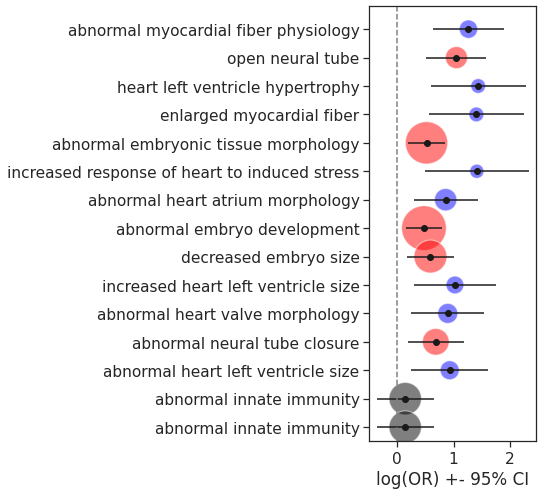

In [114]:
plt.figure(figsize=(3,8))

plt.errorbar(root_KO_df.loc[terms_plot]['log_OR'],np.arange(len(terms_plot)),
            xerr=[np.subtract(root_KO_df.loc[terms_plot]['log_OR'],root_KO_df.loc[terms_plot]['log_OR_CI_lower']),
                   np.subtract(root_KO_df.loc[terms_plot]['log_OR_CI_upper'],root_KO_df.loc[terms_plot]['log_OR'])],color='k',fmt='o')

color_temp = root_KO_df.loc[terms_plot]['MPO_term_type'].map({'Neural tube':'red','neg_ctrl':'black', 'heart':'blue'})

sns.scatterplot(x=root_KO_df.loc[terms_plot]['log_OR'],
                y=np.arange(len(terms_plot)),size=root_KO_df.loc[terms_plot]['num_genes_in_term'],sizes=(200, 2000),
                alpha=.5,
               hue=color_temp.tolist(),palette={'blue':'blue','red':'red','black':'black'},legend=False)

plt.yticks(np.arange(len(terms_plot)),root_KO_df.loc[terms_plot]['MP_description'])
plt.xticks([0,1,2])
plt.xlabel('log(OR) +- 95% CI')

plt.plot([0,0],[-.8,len(terms_plot)-.5],'--',color='gray')
plt.ylim([-0.8,len(terms_plot)-.5])

plt.gca().invert_yaxis()
# plt.savefig('ASD_CHD_brain_heart_MPO_root_enrichment_210813.png',dpi=300,bbox_inches='tight')

In [100]:
root_KO_df

,MPO_term_type,MP_description,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term
MP:0000929,Neural tube,open neural tube,0.000016,1.106295,0.604486,1.608104,240
MP:0001672,Neural tube,abnormal embryo development,0.000055,0.605600,0.311451,0.899750,1208
MP:0004215,heart,abnormal myocardial fiber physiology,0.000183,1.187312,0.565353,1.809271,143
MP:0002625,heart,heart left ventricle hypertrophy,0.000184,1.502543,0.715022,2.290065,68
MP:0003720,Neural tube,abnormal neural tube closure,0.000290,0.831410,0.381740,1.281079,384
MP:0002151,Neural tube,abnormal neural tube morphology,0.000349,0.701972,0.317257,1.086686,603
MP:0004485,heart,increased response of heart to induced stress,0.000375,1.545706,0.693949,2.397463,56
MP:0002621,Neural tube,delayed neural tube closure,0.001682,1.681851,0.632464,2.731237,33
MP:0002085,Neural tube,abnormal embryonic tissue morphology,0.001692,0.512033,0.192373,0.831693,1078
MP:0000266,heart,abnormal heart morphology,0.002642,0.395950,0.137831,0.654068,1986
